In [197]:
#! pip install tensorflow

In [198]:
#! pip install optree

In [199]:
import os
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import itertools

import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler




In [200]:
train_df = pd.read_csv('/Users/macbookpro/Desktop/lxc/git/Revenue-Radar/Data/train_df.csv')

null = []
for n in train_df.columns:
    if train_df[n].nunique(dropna=False) == 1:
        null.append(n)

null

/var/folders/9z/gkk8fkkj0pz746hrzcw69dq40000gn/T/ipykernel_28426/3349513412.py:1: DtypeWarning:

Columns (2,34) have mixed types. Specify dtype option on import or set low_memory=False.



[]

In [201]:
train_df.head()
train_df.columns.to_list()

['channelGrouping',
 'date',
 'fullVisitorId',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.operatingSystem',
 'device.isMobile',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'geoNetwork.networkDomain',
 'totals.hits',
 'totals.pageviews',
 'totals.bounces',
 'totals.newVisits',
 'totals.transactionRevenue',
 'trafficSource.campaign',
 'trafficSource.source',
 'trafficSource.medium',
 'trafficSource.keyword',
 'trafficSource.isTrueDirect',
 'trafficSource.referralPath',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adContent',
 'trafficSource.campaignCode']

In [202]:

columns = sorted(train_df.columns.tolist())
grouped_columns = [list(group) for key, group in itertools.groupby(columns, lambda x: x[0])]

for group in grouped_columns:
    print(", ".join(group))

channelGrouping
date, device.browser, device.deviceCategory, device.isMobile, device.operatingSystem
fullVisitorId
geoNetwork.city, geoNetwork.continent, geoNetwork.country, geoNetwork.metro, geoNetwork.networkDomain, geoNetwork.region, geoNetwork.subContinent
totals.bounces, totals.hits, totals.newVisits, totals.pageviews, totals.transactionRevenue, trafficSource.adContent, trafficSource.adwordsClickInfo.adNetworkType, trafficSource.adwordsClickInfo.gclId, trafficSource.adwordsClickInfo.isVideoAd, trafficSource.adwordsClickInfo.page, trafficSource.adwordsClickInfo.slot, trafficSource.campaign, trafficSource.campaignCode, trafficSource.isTrueDirect, trafficSource.keyword, trafficSource.medium, trafficSource.referralPath, trafficSource.source
visitId, visitNumber, visitStartTime


In [203]:
#drop the columns that have not available in demo dataset
columns_to_drop = [col for col in train_df.columns if train_df[col].eq('NaN').any()]
df_dropped = train_df.drop(columns=columns_to_drop)

In [204]:
#check the na percentage compare to total data
na_percentage = df_dropped.isna().sum() / len(df_dropped)
na_percentage = na_percentage.sort_values(ascending=False)

na_percentage

trafficSource.campaignCode                      0.999999
trafficSource.adContent                         0.987887
totals.transactionRevenue                       0.987257
trafficSource.adwordsClickInfo.isVideoAd        0.976252
trafficSource.adwordsClickInfo.adNetworkType    0.976252
trafficSource.adwordsClickInfo.slot             0.976252
trafficSource.adwordsClickInfo.page             0.976252
trafficSource.adwordsClickInfo.gclId            0.976140
trafficSource.isTrueDirect                      0.696781
trafficSource.referralPath                      0.633774
trafficSource.keyword                           0.556551
totals.bounces                                  0.501324
totals.newVisits                                0.221980
totals.pageviews                                0.000111
trafficSource.medium                            0.000000
trafficSource.source                            0.000000
trafficSource.campaign                          0.000000
channelGrouping                

Percentage of customers producing revenue: 1.40%

In [205]:
# Calculating and printing the percentage of customers who generate revenue.
# This process involves grouping the dataset by unique customer IDs to sum up their total transaction revenue
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

# converting the revenue data to numeric format and handling any non-numeric values by coercion to NaN
gdf["totals.transactionRevenue"] = pd.to_numeric(gdf["totals.transactionRevenue"], errors="coerce")

# then dropping any rows with NaN values in the revenue column to ensure data integrity.
gdf = gdf.dropna(subset=["totals.transactionRevenue"])

# The revenue data is intended to be sorted in ascending order to facilitate the calculation of the percentage of revenue-generating customers.
gdf["totals.transactionRevenue"] = np.sort(gdf["totals.transactionRevenue"])

# Finally, the script calculates the total number of customers and the number of those generating more than 0 revenue,
total_customers = gdf.shape[0]
revenue_customers = gdf[gdf["totals.transactionRevenue"] > 0].shape[0]
percentage_revenue_customers = (revenue_customers / total_customers) * 100

# computing the percentage of revenue-generating customers relative to the total customer base and printing the result.
print("Percentage of customers producing revenue: {:.2f}%".format(percentage_revenue_customers))

Percentage of customers producing revenue: 1.40%


## Regression model on revenue (Only with data that percentage of customers producing data)

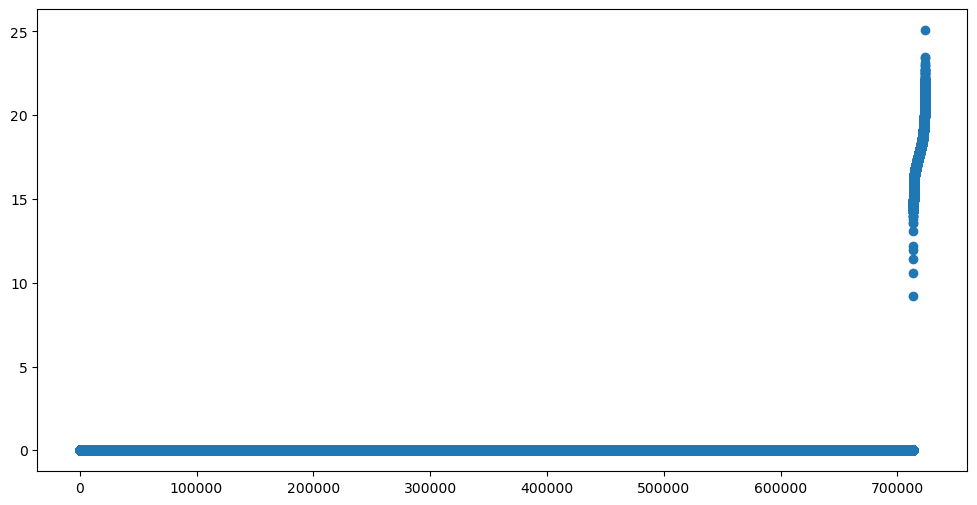

In [206]:
# Plotting the distribution of the total revenue
plt.figure(figsize=(12,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))

In [207]:
# check how many data we have for each column
count = df_dropped.count()
count = count.sort_values(ascending=False)
count

channelGrouping                                 903653
geoNetwork.subContinent                         903653
trafficSource.medium                            903653
trafficSource.source                            903653
trafficSource.campaign                          903653
date                                            903653
geoNetwork.networkDomain                        903653
geoNetwork.city                                 903653
geoNetwork.metro                                903653
geoNetwork.region                               903653
geoNetwork.country                              903653
totals.hits                                     903653
geoNetwork.continent                            903653
visitStartTime                                  903653
fullVisitorId                                   903653
device.deviceCategory                           903653
visitNumber                                     903653
visitId                                         903653
device.bro

In [208]:
"""
trafficSource.campaignCode                      0.999999
trafficSource.adContent                         0.987887
totals.transactionRevenue                       0.987257
trafficSource.adwordsClickInfo.isVideoAd        0.976252
trafficSource.adwordsClickInfo.adNetworkType    0.976252
trafficSource.adwordsClickInfo.slot             0.976252
trafficSource.adwordsClickInfo.page             0.976252
trafficSource.adwordsClickInfo.gclId            0.976140
trafficSource.isTrueDirect                      0.696781
trafficSource.referralPath                      0.633774
trafficSource.keyword                           0.556551
totals.bounces                                  0.501324
"""
#drop these columns
df_1 = df_dropped.drop(columns=['trafficSource.campaignCode', 'trafficSource.adContent', 
                                       'trafficSource.adwordsClickInfo.isVideoAd', 
                                      'trafficSource.adwordsClickInfo.adNetworkType', 
                                      'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.page', 
                                      'trafficSource.adwordsClickInfo.gclId', 
                                      'trafficSource.isTrueDirect', 'trafficSource.referralPath', 
                                      'trafficSource.keyword', 'totals.bounces', 'fullVisitorId', 'visitId'])

# what if drop na
df_2 = df_1.dropna()

# check how many data left
count1 = df_1.count()
count1 = count1.sort_values(ascending=False)

count2 = df_2.count()
count2 = count2.sort_values(ascending=False)


print(count1)
print(count2)


channelGrouping              903653
geoNetwork.country           903653
trafficSource.source         903653
trafficSource.campaign       903653
totals.hits                  903653
geoNetwork.networkDomain     903653
geoNetwork.city              903653
geoNetwork.metro             903653
date                         903653
geoNetwork.region            903653
geoNetwork.subContinent      903653
geoNetwork.continent         903653
device.deviceCategory        903653
device.isMobile              903653
device.operatingSystem       903653
device.browser               903653
visitStartTime               903653
visitNumber                  903653
trafficSource.medium         903653
totals.pageviews             903553
totals.newVisits             703060
totals.transactionRevenue     11515
dtype: int64
channelGrouping              4465
date                         4465
trafficSource.source         4465
trafficSource.campaign       4465
totals.transactionRevenue    4465
totals.newVisits         

In [209]:
df_2 = df_1.copy()

In [210]:
# only use the data that has transaction revenue
df_2 = df_2[df_2['totals.transactionRevenue'] > 0]

# check how many data left
count2 = df_2.count()
count2 = count2.sort_values(ascending=False)
count2

channelGrouping              11515
date                         11515
trafficSource.source         11515
trafficSource.campaign       11515
totals.transactionRevenue    11515
totals.pageviews             11515
totals.hits                  11515
geoNetwork.networkDomain     11515
geoNetwork.city              11515
geoNetwork.metro             11515
geoNetwork.region            11515
geoNetwork.country           11515
geoNetwork.subContinent      11515
geoNetwork.continent         11515
device.deviceCategory        11515
device.isMobile              11515
device.operatingSystem       11515
device.browser               11515
visitStartTime               11515
visitNumber                  11515
trafficSource.medium         11515
totals.newVisits              4465
dtype: int64

In [211]:
import pandas as pd

# Assuming df_2 is your DataFrame and has already been loaded

# Step 1: Convert 'totals.newVisits' to categorical
df_2['totals.newVisits'] = df_2['totals.newVisits'].astype('category')

# Check unique values before making changes
print("Unique values before:", df_2['totals.newVisits'].unique())

# Step 2: Fill NA/NaN values with 0
df_2['totals.newVisits'] = df_2['totals.newVisits'].cat.add_categories([0]).fillna(0)

# Step 3: Ensure all values are either 1 or 0
df_2['totals.newVisits'] = df_2['totals.newVisits'].apply(lambda x: 1 if x == 1 else 0).astype('category')

# Check unique values after making changes
print("Unique values after:", df_2['totals.newVisits'].unique())


Unique values before: [1.0, NaN]
Categories (1, float64): [1.0]
Unique values after: [1, 0]
Categories (2, int64): [1, 0]


/var/folders/9z/gkk8fkkj0pz746hrzcw69dq40000gn/T/ipykernel_28426/805069265.py:9: FutureWarning:

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.



In [212]:
df_2.head()

,channelGrouping,date,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,...,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium
752,Direct,20160902,1,1472843572,Chrome,Linux,False,desktop,Americas,Northern America,...,Detroit MI,Ann Arbor,(not set),11,11.0,1,37860000.0,(not set),(direct),(none)
753,Organic Search,20160902,3,1472844906,Chrome,Macintosh,False,desktop,Americas,Northern America,...,New York NY,New York,(not set),11,10.0,0,306670000.0,(not set),google,organic
799,Referral,20160902,7,1472827393,Chrome,Linux,False,desktop,Americas,Northern America,...,New York NY,New York,(not set),13,11.0,0,68030000.0,(not set),mall.googleplex.com,referral
802,Referral,20160902,6,1472846398,Chrome,Windows,False,desktop,Americas,Northern America,...,San Francisco-Oakland-San Jose CA,Mountain View,(not set),13,12.0,0,26250000.0,(not set),mall.googleplex.com,referral
859,Referral,20160902,4,1472824817,Chrome,Macintosh,False,desktop,Americas,Northern America,...,not available in demo dataset,not available in demo dataset,(not set),17,14.0,0,574150000.0,(not set),mall.googleplex.com,referral


In [213]:
# make date to datetime
df_2['date'] = pd.to_datetime(df_2['date'], format='%Y%m%d')

In [214]:
df_2.dtypes

channelGrouping                      object
date                         datetime64[ns]
visitNumber                           int64
visitStartTime                        int64
device.browser                       object
device.operatingSystem               object
device.isMobile                        bool
device.deviceCategory                object
geoNetwork.continent                 object
geoNetwork.subContinent              object
geoNetwork.country                   object
geoNetwork.region                    object
geoNetwork.metro                     object
geoNetwork.city                      object
geoNetwork.networkDomain             object
totals.hits                           int64
totals.pageviews                    float64
totals.newVisits                   category
totals.transactionRevenue           float64
trafficSource.campaign               object
trafficSource.source                 object
trafficSource.medium                 object
dtype: object

# NOT include Time Series


In [215]:
#type of each row
df_2.dtypes
#drop the date
df_3 = df_2.drop(columns=['geoNetwork.metro','geoNetwork.networkDomain','visitNumber','geoNetwork.city',
                          'visitStartTime','trafficSource.source'])
df_3.head()

,channelGrouping,date,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.medium
752,Direct,2016-09-02,Chrome,Linux,False,desktop,Americas,Northern America,United States,Michigan,11,11.0,1,37860000.0,(not set),(none)
753,Organic Search,2016-09-02,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,New York,11,10.0,0,306670000.0,(not set),organic
799,Referral,2016-09-02,Chrome,Linux,False,desktop,Americas,Northern America,United States,New York,13,11.0,0,68030000.0,(not set),referral
802,Referral,2016-09-02,Chrome,Windows,False,desktop,Americas,Northern America,United States,California,13,12.0,0,26250000.0,(not set),referral
859,Referral,2016-09-02,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,17,14.0,0,574150000.0,(not set),referral


In [216]:
#check the unique value of each column for categorical data
for col in df_3.columns:
    if df_3[col].dtype == 'object':
        print(col, df_3[col].nunique())
        print('\n')
        # print each unique value
        print(df_3[col].unique())
        print('\n')
        # print the value counts
        print(df_3[col].value_counts())
    else:
        continue


        

channelGrouping 8


['Direct' 'Organic Search' 'Referral' 'Display' 'Paid Search' 'Social'
 'Affiliates' '(Other)']


Referral          5311
Organic Search    3438
Direct            2042
Paid Search        468
Display            142
Social             104
Affiliates           9
(Other)              1
Name: channelGrouping, dtype: int64
device.browser 9


['Chrome' 'Safari' 'Firefox' 'Safari (in-app)' 'Edge' 'Internet Explorer'
 'Android Webview' 'Opera' 'Amazon Silk']


Chrome               10353
Safari                 780
Firefox                191
Internet Explorer      109
Edge                    58
Safari (in-app)         12
Android Webview          6
Opera                    5
Amazon Silk              1
Name: device.browser, dtype: int64
device.operatingSystem 7


['Linux' 'Macintosh' 'Windows' 'Android' 'Chrome OS' 'iOS' 'Windows Phone']


Macintosh        6426
Windows          2309
Chrome OS         994
Linux             782
iOS               536
Android           467
Windows Ph

## clean the region

In [217]:
df_4 = df_3.drop(columns=['geoNetwork.subContinent','trafficSource.campaign','geoNetwork.continent'])



In [218]:
# return the unique value of geoNetwork.country
df_4['geoNetwork.country'].unique()

array(['United States', 'Puerto Rico', 'Taiwan', 'Switzerland', 'Canada',
       'Mexico', 'Australia', 'Sweden', 'Ireland', 'Israel', 'Germany',
       'United Kingdom', 'New Zealand', 'Argentina', 'Chile', 'Finland',
       'India', 'Venezuela', 'Indonesia', 'St. Lucia', 'Japan', 'China',
       'Colombia', 'Hong Kong', 'Brazil', 'Philippines', '(not set)',
       'Pakistan', 'South Korea', 'Ecuador', 'Singapore', 'Hungary',
       'Greece', 'Russia', 'Kuwait', 'Malaysia', 'Spain', 'Ukraine',
       'Cyprus', 'Romania', 'Nigeria', 'Uruguay', 'Belgium', 'Kenya',
       'Kazakhstan', 'Turkey', 'Saudi Arabia', 'Anguilla', 'Armenia',
       'France', 'United Arab Emirates', 'Thailand', 'Netherlands',
       'South Africa', 'Poland', 'Egypt', 'Italy', 'Guatemala', 'Georgia',
       'El Salvador', 'Lebanon', 'Nicaragua', 'Czechia', 'Denmark',
       'Curaçao', 'Peru', 'Panama', 'Portugal', 'Guadeloupe'],
      dtype=object)

In [219]:
# count the number of county of geoNetwork.country 
df_4['geoNetwork.country'].value_counts()

United States    10953
Canada             190
Venezuela           63
Mexico              20
Taiwan              19
                 ...  
Anguilla             1
Pakistan             1
Egypt                1
Hungary              1
Guadeloupe           1
Name: geoNetwork.country, Length: 69, dtype: int64

In [220]:


# Assuming your DataFrame is named df (replace with the actual name of your DataFrame)

# Filter the DataFrame to include only rows where 'geoNetwork.country' is 'United States' or 'Canada' or Mexcio
df_4 = df_4[df_4['geoNetwork.country'].isin(['United States', 'Canada','Mexico'])]

# drop country column
df_4 = df_4.drop(columns=['geoNetwork.country'])

# Now, filtered_df contains only the rows with 'United States' and 'Canada'


print(df_4['geoNetwork.region'].unique())


['Michigan' 'New York' 'California' 'not available in demo dataset'
 'Washington' 'Illinois' 'Oregon' 'District of Columbia' 'Massachusetts'
 '(not set)' 'Virginia' 'Georgia' 'Texas' 'Ontario' 'Pennsylvania'
 'Nevada' 'North Carolina' 'State of Rio de Janeiro' 'Colorado'
 'New Jersey' 'Mexico City' 'Florida' 'Nebraska' 'South Carolina' 'Utah'
 'Tennessee' 'Alberta' 'Zulia' 'Arizona' 'Ohio' 'Quebec' 'Iowa'
 'British Columbia' 'Catalonia' 'Missouri' 'Vienna' 'Maryland' 'Minnesota'
 'England' 'Indiana' 'Connecticut' 'Wisconsin']


In [221]:
import pandas as pd

# Assuming your DataFrame is named df and already has 'Unknown' consolidated
other =[]
# Define the states as 'West' or 'East'
us_east = ['New York', 'Massachusetts', 'District of Columbia', 'Virginia', 'Georgia', 'Ontario', 'Pennsylvania', 'North Carolina', 'New Jersey', 'Florida', 'South Carolina', 'England','Tennessee', 'Ohio', 'Maryland', 'Indiana', 'Connecticut']
us_west = ['California', 'Washington', 'Oregon', 'Nevada', 'Colorado', 'Arizona', 'British Columbia']
us_middle = ['Michigan', 'Illinois', 'Texas', 'Nebraska', 'Utah', 'Alberta', 'Missouri', 'Iowa', 'Minnesota', 'Wisconsin']
mexico = ['Mexico City']
canada = ['Ontario', 'Quebec', 'Alberta', 'British Columbia']

# Function to categorize each state
def categorize_state(region):
    if region in us_west:
        return 'West'
    elif region in us_east:
        return 'East'
    elif region in us_middle:
        return 'Middle'
    elif region in mexico:
        return 'Mexico'
    elif region in canada:
        return 'Canada'
    else:
        #show me what is left
        other.append(region)
        return 'Unknown'


# Apply the categorization
df_4['geoNetwork.region'] = df_4['geoNetwork.region'].apply(categorize_state)

# Check the new categorization
print(df_4['geoNetwork.region'].value_counts())

Unknown    4430
West       3707
East       2066
Middle      942
Canada       11
Mexico        7
Name: geoNetwork.region, dtype: int64


In [222]:
other

['not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not available in demo dataset',
 'not availabl

In [223]:
# drop geo.region Unknown 
df_4 = df_4[df_4['geoNetwork.region'] != 'Unknown']

## clean Channel Grouping

In [224]:
df_4['channelGrouping'] = df_4['channelGrouping'].replace(['Social', 'Display', 'Affiliates', '(Other)'], 'Other')
print(df_4['channelGrouping'].value_counts())


browsers_to_keep = ['Chrome']
df_4['device.browser'] = df_4['device.browser'].apply(lambda x: x if x in browsers_to_keep else 'Rest')
# After the modification, to see the count of each category, you can use value_counts()
print(df_4['device.browser'].value_counts())


# For the 'device.operatingSystem' column
# Replace 'Macintosh' with 'Mac', 'Windows' remains the same, and classify others as 'Mobile'
df_4['device.operatingSystem'] = df_4['device.operatingSystem'].replace(['Linux', 'Android', 'iOS', 'Chrome OS','Windows Phone'], 'Mobile')
df_4['device.operatingSystem'] = df_4['device.operatingSystem'].replace(['Macintosh'], 'Mac')

# Assuming 'device.deviceCategory' needs to be updated based on 'device.operatingSystem'
# This step seems a bit confusing because 'deviceCategory' typically indicates the type of device (e.g., desktop, mobile, tablet)
# If you intended to classify 'deviceCategory' based on 'operatingSystem', let's clarify the approach:
# - 'Mac' and 'Windows' could be considered 'desktop' in many contexts
# - 'Mobile' could map to 'mobile' and 'tablet'
# If the task is to adjust 'device.deviceCategory' based on these new 'operatingSystem' categories:
df_4['device.deviceCategory'] = df_4['device.operatingSystem'].apply(lambda x: 'desktop' if x in ['Mac', 'Windows'] else 'mobile')

# drop device category
df_4 = df_4.drop(columns=['device.deviceCategory'])

# After reclassification, to see the count of each category in 'device.operatingSystem'
print(df_4['device.operatingSystem'].value_counts())


df_4['geoNetwork.region'] = df_4['geoNetwork.region'].replace(['not available in demo dataset', '(not set)'], 'Unknown')


Referral          4055
Organic Search    1277
Direct            1079
Paid Search        170
Other              152
Name: channelGrouping, dtype: int64
Chrome    6376
Rest       357
Name: device.browser, dtype: int64
Mac        4355
Mobile     1628
Windows     750
Name: device.operatingSystem, dtype: int64


In [225]:
for col in df_4.columns:
    if df_4[col].dtype == 'object':
        print(col, df_4[col].nunique())
        print('\n')
        # print each unique value
        print(df_4[col].unique())
        print('\n')
        # print the value counts
        print(df_4[col].value_counts())
    else:
        continue


channelGrouping 5


['Direct' 'Organic Search' 'Referral' 'Other' 'Paid Search']


Referral          4055
Organic Search    1277
Direct            1079
Paid Search        170
Other              152
Name: channelGrouping, dtype: int64
device.browser 2


['Chrome' 'Rest']


Chrome    6376
Rest       357
Name: device.browser, dtype: int64
device.operatingSystem 3


['Mobile' 'Mac' 'Windows']


Mac        4355
Mobile     1628
Windows     750
Name: device.operatingSystem, dtype: int64
geoNetwork.region 5


['Middle' 'East' 'West' 'Mexico' 'Canada']


West      3707
East      2066
Middle     942
Canada      11
Mexico       7
Name: geoNetwork.region, dtype: int64
trafficSource.medium 7


['(none)' 'organic' 'referral' 'cpm' 'cpc' 'affiliate' '(not set)']


referral     4106
organic      1277
(none)       1079
cpc           170
cpm            97
affiliate       3
(not set)       1
Name: trafficSource.medium, dtype: int64


In [226]:
df_4['trafficSource.medium'] = df_4['trafficSource.medium'].replace('(none)', 'none')

# Combine 'cpc', 'cpm', 'affiliate', and '(not set)' into 'rest'
df_4['trafficSource.medium'] = df_4['trafficSource.medium'].replace(['cpc', 'cpm', 'affiliate', '(not set)'], 'rest')

# After reclassification, to see the count of each category
print(df_4['trafficSource.medium'].value_counts())

referral    4106
organic     1277
none        1079
rest         271
Name: trafficSource.medium, dtype: int64


In [227]:
for col in df_4.columns:
    if df_4[col].dtype == 'object':
        print(col, df_4[col].nunique())
        print('\n')
        # print each unique value
        print(df_4[col].unique())
        print('\n')
        # print the value counts
        print(df_4[col].value_counts())
    else:
        continue


channelGrouping 5


['Direct' 'Organic Search' 'Referral' 'Other' 'Paid Search']


Referral          4055
Organic Search    1277
Direct            1079
Paid Search        170
Other              152
Name: channelGrouping, dtype: int64
device.browser 2


['Chrome' 'Rest']


Chrome    6376
Rest       357
Name: device.browser, dtype: int64
device.operatingSystem 3


['Mobile' 'Mac' 'Windows']


Mac        4355
Mobile     1628
Windows     750
Name: device.operatingSystem, dtype: int64
geoNetwork.region 5


['Middle' 'East' 'West' 'Mexico' 'Canada']


West      3707
East      2066
Middle     942
Canada      11
Mexico       7
Name: geoNetwork.region, dtype: int64
trafficSource.medium 4


['none' 'organic' 'referral' 'rest']


referral    4106
organic     1277
none        1079
rest         271
Name: trafficSource.medium, dtype: int64


In [228]:
df_4.drop(columns=['device.isMobile'], inplace=True)    


In [229]:
# splitting the date column into year, month and day
df_4['month']=df_4['date'].dt.month
df_4['day']=df_4['date'].dt.day
df_4['year']=df_4['date'].dt.year

In [230]:
# bucketing month into quarters
def quarter(x):
    if x in [1,2,3]:
        return '1st_quarter'
    elif x in [4,5,6]:
        return '2nd_quarter'
    elif x in [7,8,9]:
        return '3rd_quarter'
    else:
        return '4th_quarter'
    
df_4['quarter']=df_4['month'].apply(quarter)

In [231]:
# bucking the day column into beginning, middle and end of the month
def day(x):
    if x in range(1,11):
        return 'beginning'
    elif x in range(11,21):
        return 'middle'
    else:
        return 'end'

df_4['day_of_month']=df_4['day'].apply(day)


In [232]:
df_4.drop(columns=['date'], inplace=True)

In [233]:
df_4.head()

,channelGrouping,device.browser,device.operatingSystem,geoNetwork.region,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.medium,month,day,year,quarter,day_of_month
752,Direct,Chrome,Mobile,Middle,11,11.0,1,37860000.0,none,9,2,2016,3rd_quarter,beginning
753,Organic Search,Chrome,Mac,East,11,10.0,0,306670000.0,organic,9,2,2016,3rd_quarter,beginning
799,Referral,Chrome,Mobile,East,13,11.0,0,68030000.0,referral,9,2,2016,3rd_quarter,beginning
802,Referral,Chrome,Windows,West,13,12.0,0,26250000.0,referral,9,2,2016,3rd_quarter,beginning
866,Referral,Chrome,Mobile,West,17,17.0,0,8380000.0,referral,9,2,2016,3rd_quarter,beginning


In [234]:
df_4.drop(columns=['month', 'day'], inplace=True)

In [235]:
# give the type of each column
df_4.dtypes

channelGrouping                object
device.browser                 object
device.operatingSystem         object
geoNetwork.region              object
totals.hits                     int64
totals.pageviews              float64
totals.newVisits             category
totals.transactionRevenue     float64
trafficSource.medium           object
year                            int64
quarter                        object
day_of_month                   object
dtype: object

In [236]:
# from sklearn.preprocessing import LabelEncoder
# # Initialize a label encoder
# label_encoder = LabelEncoder()

# # Iterate through the columns
# for column in df_4.columns:
#     if df_4[column].dtype == 'object':
#         df_4[column] = label_encoder.fit_transform(df_4[column])
#     else:
#         continue

# df_4.head()


In [237]:
df_5 = df_4.copy()

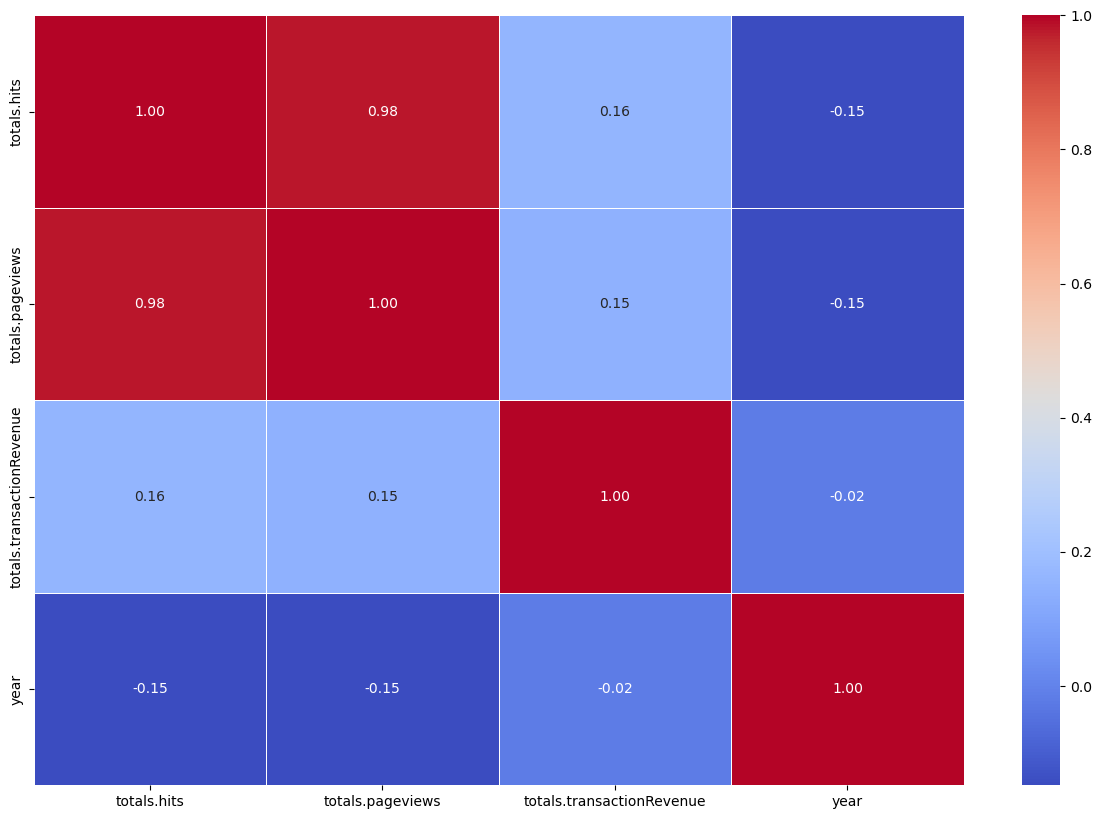

In [238]:
# show correlation only numerical data
numeric_columns = df_5.select_dtypes(include=['int64', 'float64','int32'])
corr = numeric_columns.corr()
plt.figure(figsize=(15,10))

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()


In [239]:
# drop the column that has high correlation
df_5 = df_5.drop(columns=['totals.hits', 'year'])

In [240]:
# convert the column to int
df_5['totals.pageviews'] = df_5['totals.pageviews'].astype(int)

# dummy the categorical data
df_5 = pd.get_dummies(df_5, columns=[ 'channelGrouping','device.browser', 'device.operatingSystem', 'geoNetwork.region', 'trafficSource.medium', 'quarter', 'day_of_month'], drop_first=True)

df_5.head()

,totals.pageviews,totals.newVisits,totals.transactionRevenue,channelGrouping_Organic Search,channelGrouping_Other,channelGrouping_Paid Search,channelGrouping_Referral,device.browser_Rest,device.operatingSystem_Mobile,device.operatingSystem_Windows,...,geoNetwork.region_Middle,geoNetwork.region_West,trafficSource.medium_organic,trafficSource.medium_referral,trafficSource.medium_rest,quarter_2nd_quarter,quarter_3rd_quarter,quarter_4th_quarter,day_of_month_end,day_of_month_middle
752,11,1,37860000.0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
753,10,0,306670000.0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
799,11,0,68030000.0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
802,12,0,26250000.0,0,0,0,1,0,0,1,...,0,1,0,1,0,0,1,0,0,0
866,17,0,8380000.0,0,0,0,1,0,1,0,...,0,1,0,1,0,0,1,0,0,0


15     0.043220
14     0.042923
16     0.042626
18     0.040844
13     0.040398
         ...   
128    0.000149
115    0.000149
143    0.000149
102    0.000149
139    0.000149
Name: totals.pageviews, Length: 134, dtype: float64


0    0.652607
1    0.347393
Name: totals.newVisits, dtype: float64


33590000.0     0.023764
44790000.0     0.019753
13590000.0     0.015446
16990000.0     0.011882
19190000.0     0.011288
                 ...   
121450000.0    0.000149
80630000.0     0.000149
25580000.0     0.000149
119750000.0    0.000149
69390000.0     0.000149
Name: totals.transactionRevenue, Length: 3531, dtype: float64


0    0.810337
1    0.189663
Name: channelGrouping_Organic Search, dtype: float64


0    0.977425
1    0.022575
Name: channelGrouping_Other, dtype: float64


0    0.974751
1    0.025249
Name: channelGrouping_Paid Search, dtype: float64


1    0.602258
0    0.397742
Name: channelGrouping_Referral, dtype: float64


0    0.946978
1    0.053022
Name: device.browser_Rest, dtyp

/var/folders/9z/gkk8fkkj0pz746hrzcw69dq40000gn/T/ipykernel_28426/2020264285.py:7: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



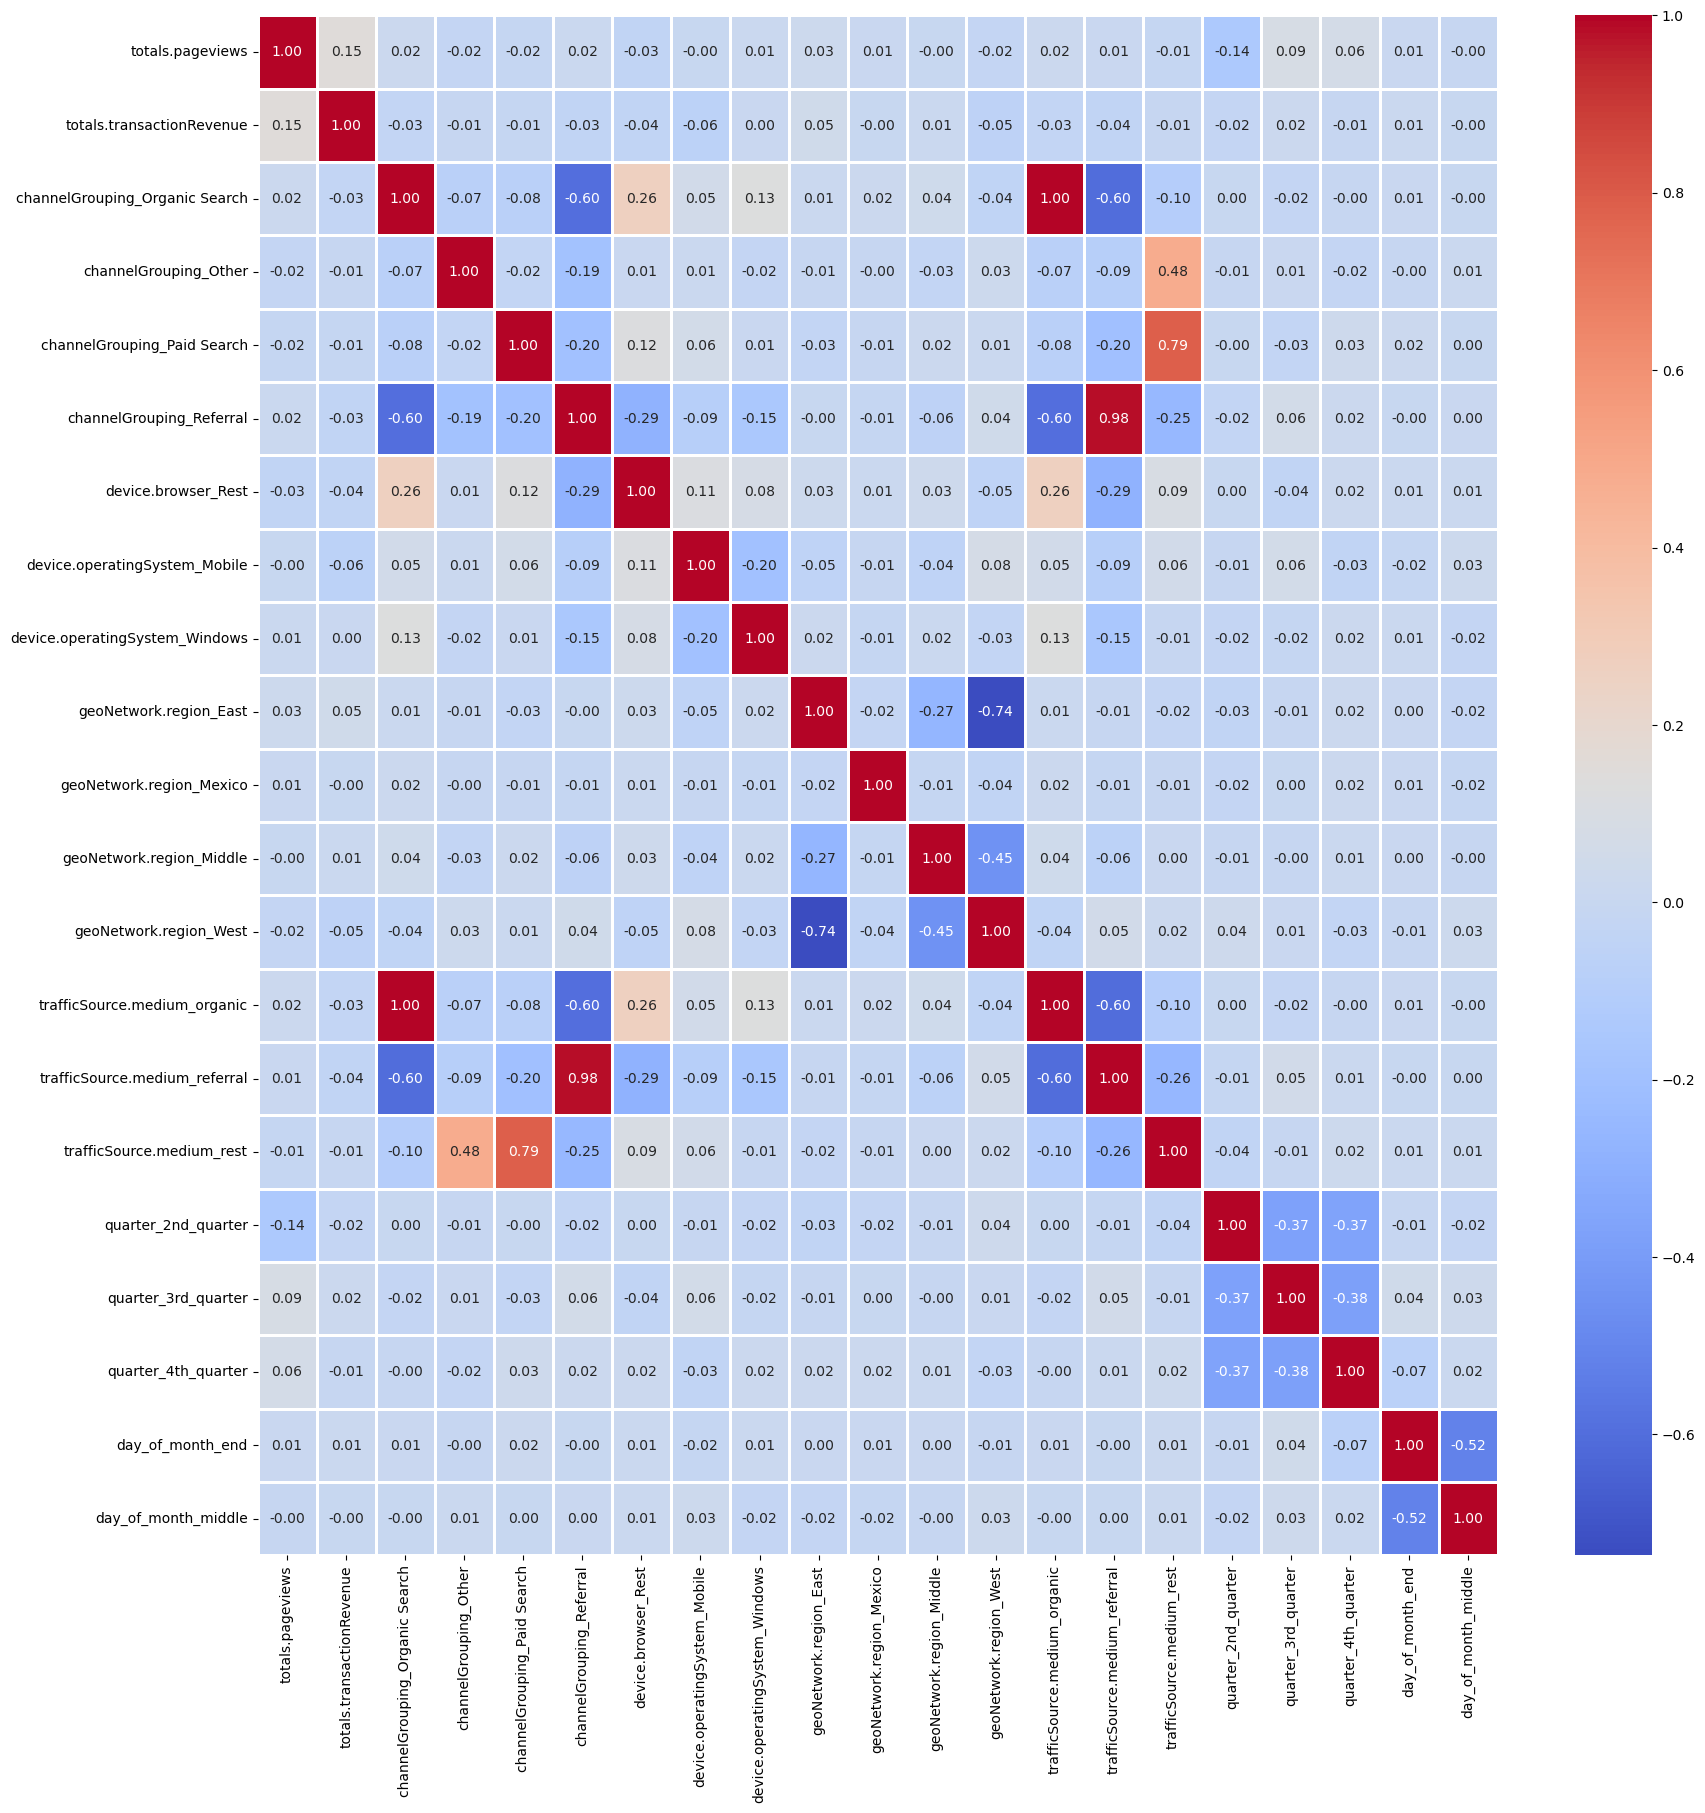

In [241]:
# give me the percentage of each value in the column
for column in df_5.columns:
    print(df_5[column].value_counts(normalize=True))
    print('\n')

# check the correlation between the columns
correlation = df_5.corr()
correlation

# plot the correlation
plt.figure(figsize=(20,20))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.show()


In [242]:
# show me the column that has high correlation
correlation = correlation.abs()
correlation = correlation.unstack()
correlation = correlation.sort_values(ascending=False)
correlation = correlation[correlation > 0.7]
correlation = correlation[correlation < 1]
correlation = correlation.drop_duplicates()
correlation


channelGrouping_Referral   trafficSource.medium_referral    0.984262
trafficSource.medium_rest  channelGrouping_Paid Search      0.785909
geoNetwork.region_East     geoNetwork.region_West           0.736416
dtype: float64

In [243]:
# drop the column that has high correlation


df_6= df_5.drop(columns=['trafficSource.medium_referral','trafficSource.medium_organic','trafficSource.medium_rest'])


15     0.043220
14     0.042923
16     0.042626
18     0.040844
13     0.040398
         ...   
128    0.000149
115    0.000149
143    0.000149
102    0.000149
139    0.000149
Name: totals.pageviews, Length: 134, dtype: float64


0    0.652607
1    0.347393
Name: totals.newVisits, dtype: float64


33590000.0     0.023764
44790000.0     0.019753
13590000.0     0.015446
16990000.0     0.011882
19190000.0     0.011288
                 ...   
121450000.0    0.000149
80630000.0     0.000149
25580000.0     0.000149
119750000.0    0.000149
69390000.0     0.000149
Name: totals.transactionRevenue, Length: 3531, dtype: float64


0    0.810337
1    0.189663
Name: channelGrouping_Organic Search, dtype: float64


0    0.977425
1    0.022575
Name: channelGrouping_Other, dtype: float64


0    0.974751
1    0.025249
Name: channelGrouping_Paid Search, dtype: float64


1    0.602258
0    0.397742
Name: channelGrouping_Referral, dtype: float64


0    0.946978
1    0.053022
Name: device.browser_Rest, dtyp

/var/folders/9z/gkk8fkkj0pz746hrzcw69dq40000gn/T/ipykernel_28426/3768599476.py:7: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



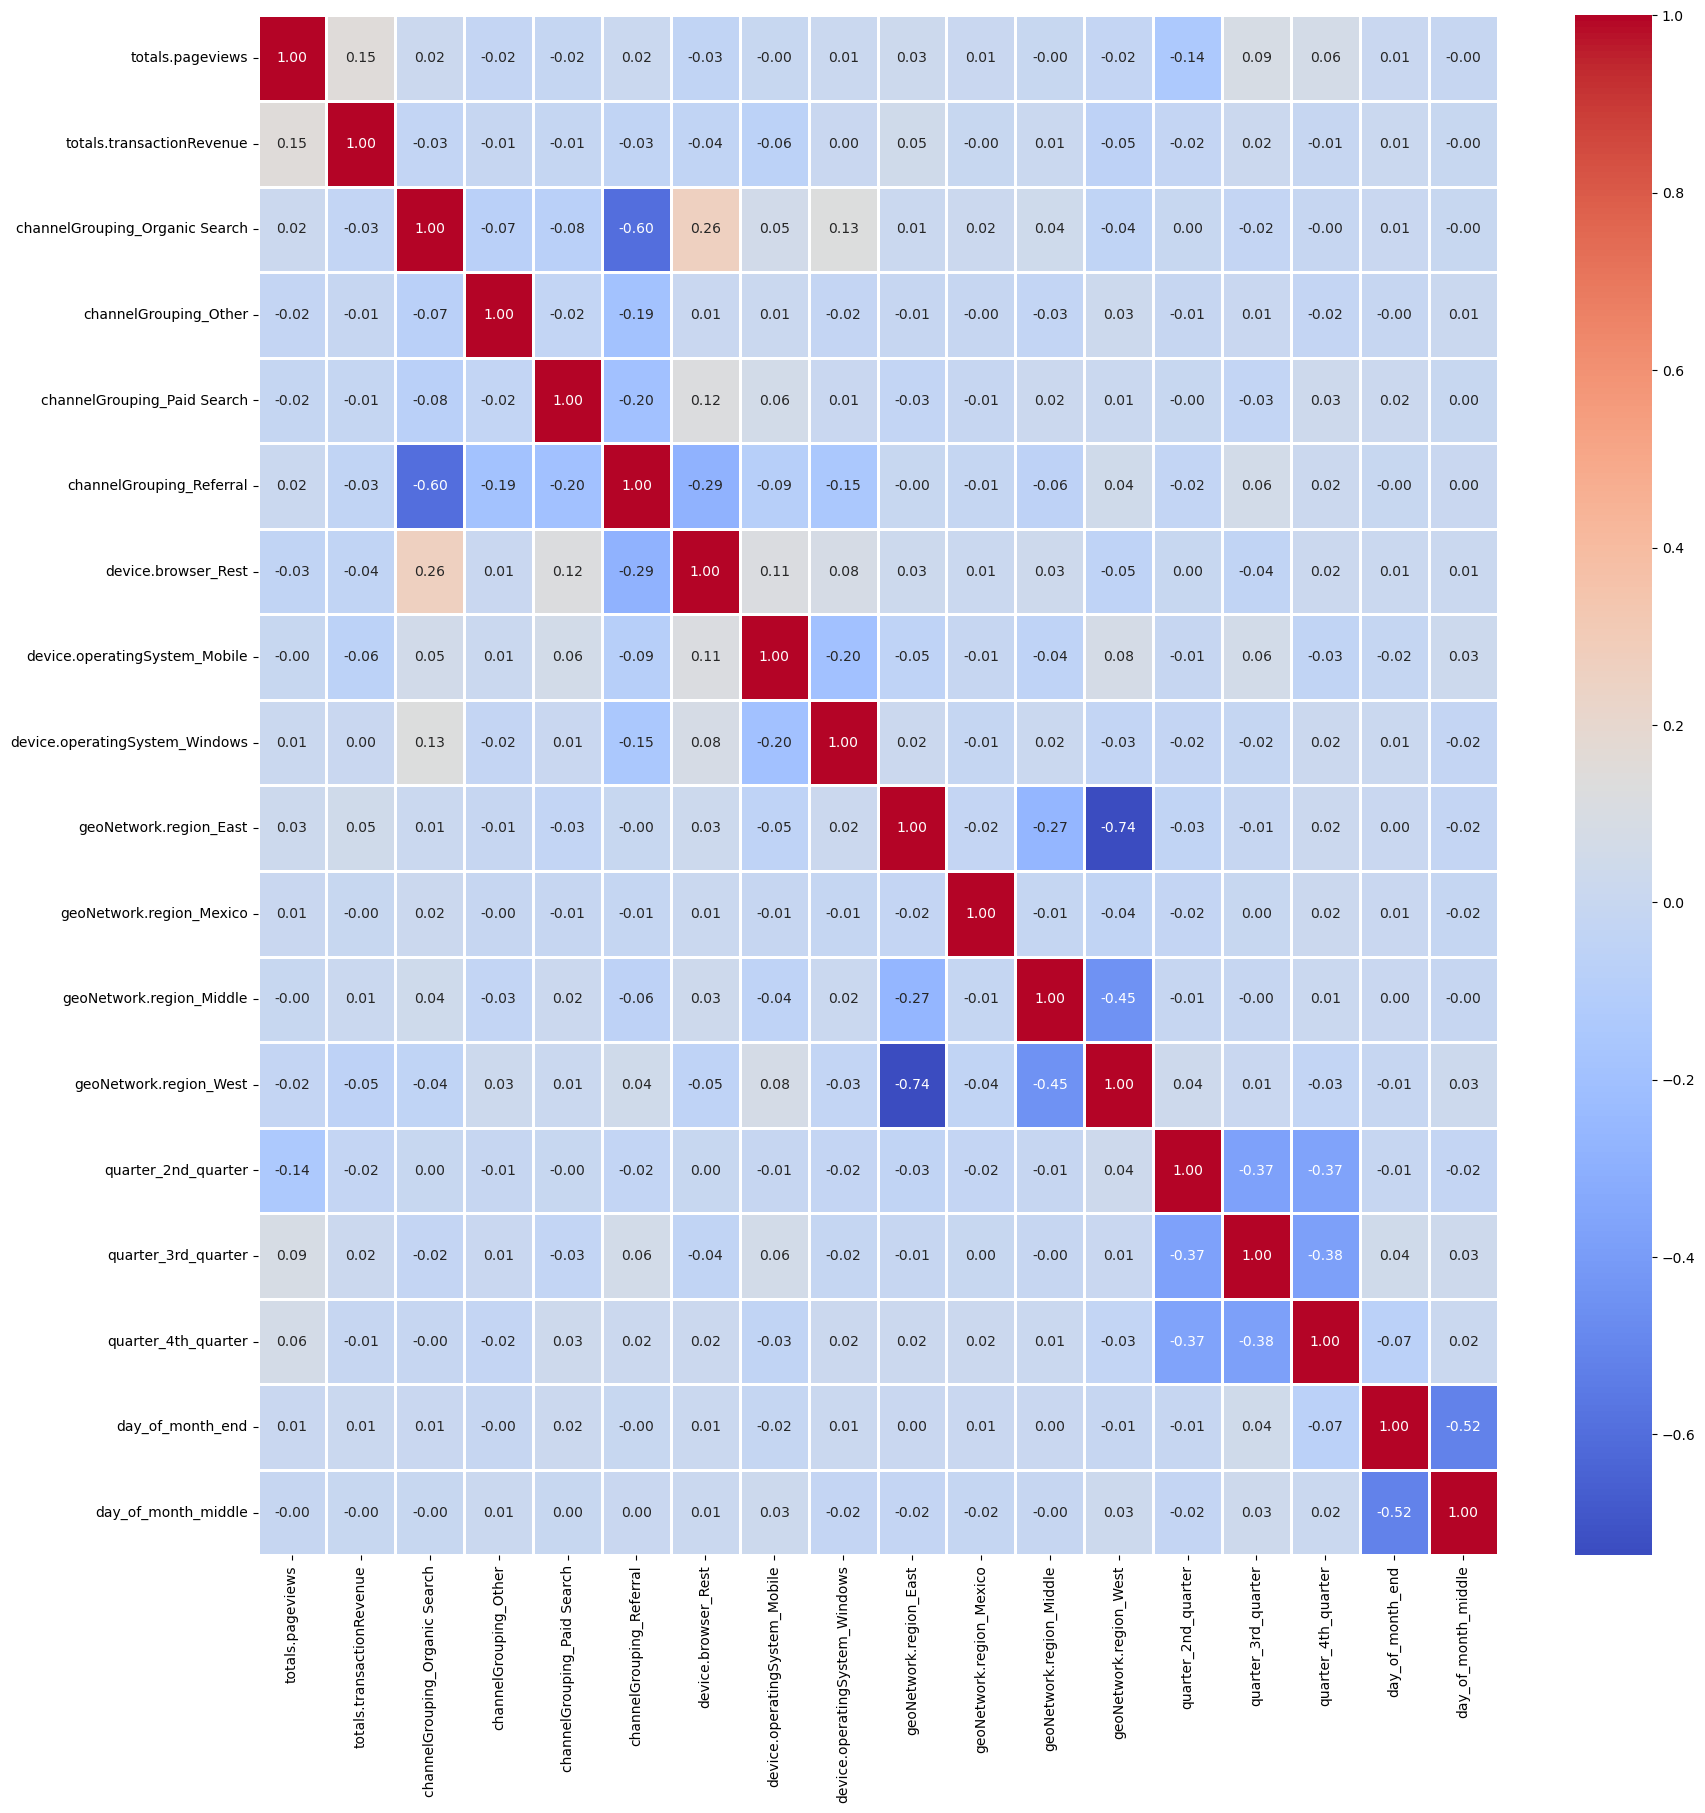

In [244]:
# give me the percentage of each value in the column
for column in df_6.columns:
    print(df_6[column].value_counts(normalize=True))
    print('\n')

# check the correlation between the columns
correlation = df_6.corr()
correlation

# plot the correlation
plt.figure(figsize=(20,20))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.show()


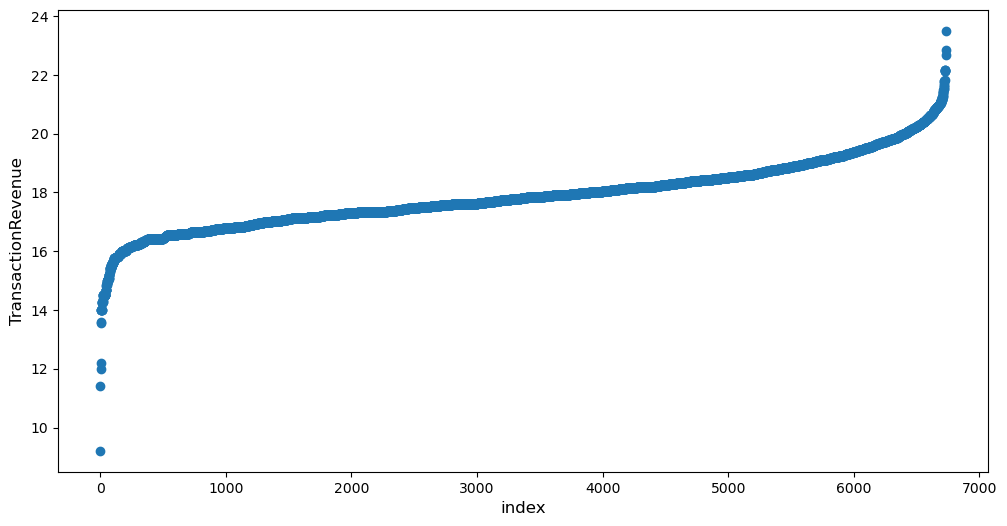

In [245]:
# plot the revenue
plt.figure(figsize=(12,6))
plt.scatter(range(df_6.shape[0]), np.sort(np.log1p(df_6["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()


In [246]:
df_7 = df_6.copy()
# get me the stats of the revenue in a table
print(df_7['totals.transactionRevenue'].min())
print(df_7['totals.transactionRevenue'].max())


10000.0
16023750000.0


In [247]:
# Min max on target
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#df_5['totals.transactionRevenue'] = scaler.fit_transform(df_5['totals.transactionRevenue'].values.reshape(-1,1))

df_7['totals.transactionRevenue'] = np.log1p(df_7['totals.transactionRevenue'].values)


In [248]:
# get me the stats of the revenue in a table
print(df_7['totals.transactionRevenue'].min())
print(df_7['totals.transactionRevenue'].max())

9.210440366976517
23.497337833653027


In [249]:
df_7.head()

,totals.pageviews,totals.newVisits,totals.transactionRevenue,channelGrouping_Organic Search,channelGrouping_Other,channelGrouping_Paid Search,channelGrouping_Referral,device.browser_Rest,device.operatingSystem_Mobile,device.operatingSystem_Windows,geoNetwork.region_East,geoNetwork.region_Mexico,geoNetwork.region_Middle,geoNetwork.region_West,quarter_2nd_quarter,quarter_3rd_quarter,quarter_4th_quarter,day_of_month_end,day_of_month_middle
752,11,1,17.449406,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
753,10,0,19.541283,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
799,11,0,18.035459,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0
802,12,0,17.083177,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0
866,17,0,15.941359,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0


## Final data 


In [250]:
# match with entreprise 1 data 
df_5 = df_7.copy()

In [251]:
df_5.head()

,totals.pageviews,totals.newVisits,totals.transactionRevenue,channelGrouping_Organic Search,channelGrouping_Other,channelGrouping_Paid Search,channelGrouping_Referral,device.browser_Rest,device.operatingSystem_Mobile,device.operatingSystem_Windows,geoNetwork.region_East,geoNetwork.region_Mexico,geoNetwork.region_Middle,geoNetwork.region_West,quarter_2nd_quarter,quarter_3rd_quarter,quarter_4th_quarter,day_of_month_end,day_of_month_middle
752,11,1,17.449406,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
753,10,0,19.541283,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
799,11,0,18.035459,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0
802,12,0,17.083177,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0
866,17,0,15.941359,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0


In [264]:
# Split the data into features and target
X = df_5.drop(columns='totals.transactionRevenue')
y = df_5['totals.transactionRevenue']

# Split the data into training, val, and testing sets 
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.model_selection import train_test_split

# First, split into training (80%) and temporary set (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Now split the temporary set into validation (50%) and test sets (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Now you have X_train, X_val, X_val and y_train, y_val, y_val
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)



(5386, 18) (673, 18) (674, 18) (5386,) (673,) (674,)


In [265]:
X_train

,totals.pageviews,totals.newVisits,channelGrouping_Organic Search,channelGrouping_Other,channelGrouping_Paid Search,channelGrouping_Referral,device.browser_Rest,device.operatingSystem_Mobile,device.operatingSystem_Windows,geoNetwork.region_East,geoNetwork.region_Mexico,geoNetwork.region_Middle,geoNetwork.region_West,quarter_2nd_quarter,quarter_3rd_quarter,quarter_4th_quarter,day_of_month_end,day_of_month_middle
376668,18,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
80473,19,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1
21332,33,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1
174687,13,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1
777550,48,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494659,17,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0
688688,27,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0
694459,21,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
716496,16,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0


In [266]:
X_train_1 = pd.DataFrame(X_train, columns=feature_names)
X_train_1.head(5)

,totals.pageviews,totals.newVisits,channelGrouping_Organic Search,channelGrouping_Other,channelGrouping_Paid Search,channelGrouping_Referral,device.browser_Rest,device.operatingSystem_Mobile,device.operatingSystem_Windows,geoNetwork.region_East,geoNetwork.region_Mexico,geoNetwork.region_Middle,geoNetwork.region_West,quarter_2nd_quarter,quarter_3rd_quarter,quarter_4th_quarter,day_of_month_end,day_of_month_middle
376668,18,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
80473,19,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1
21332,33,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1
174687,13,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1
777550,48,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


# Linear Regression

Mean Squared Error: 1.1400480656392253
Mean Absolute Error: 0.8255076089299116
Median Absolute Error: 0.6508794907695652
Cross-validated scores: [0.82990542 0.79863624 0.86193137 0.84537283 0.80381694]
Average score: 0.8279325585568011
Intercept: 17.903060685473903
Coefficients: [ 0.28139999 -0.15737261 -0.12375302 -0.02926704 -0.04614785 -0.16789194
 -0.09424072 -0.14308361 -0.06903898  0.40260223  0.03929694  0.33066085
  0.3622268   0.00515924  0.01175585 -0.01299599 -0.02727112 -0.03219939]
Features: Index(['totals.pageviews', 'totals.newVisits',
       'channelGrouping_Organic Search', 'channelGrouping_Other',
       'channelGrouping_Paid Search', 'channelGrouping_Referral',
       'device.browser_Rest', 'device.operatingSystem_Mobile',
       'device.operatingSystem_Windows', 'geoNetwork.region_East',
       'geoNetwork.region_Mexico', 'geoNetwork.region_Middle',
       'geoNetwork.region_West', 'quarter_2nd_quarter', 'quarter_3rd_quarter',
       'quarter_4th_quarter', 'day_of_m

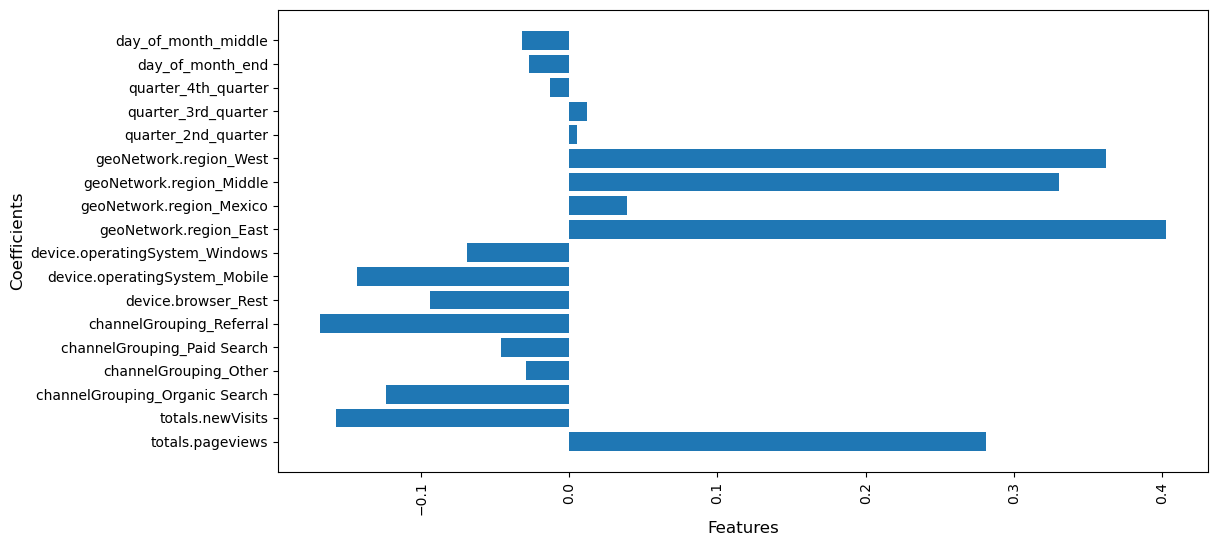

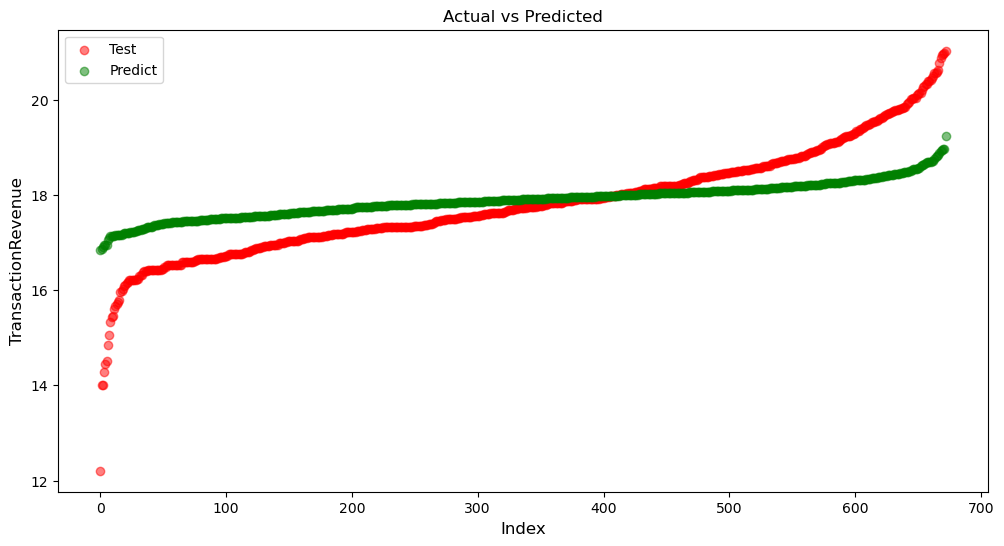

In [278]:

# Initialize a standard scaler
scaler = StandardScaler()

# Fit the scaler
scaler.fit(X_train)

# Scale the train and test data
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

# regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error, median_absolute_error

# Initialize the model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)

# Median Absolute Error
dae = median_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)




print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Median Absolute Error:", dae)



#cross validation
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validated scores
print('Cross-validated scores:', -scores)

# Print the average score
print('Average score:', -scores.mean())

# intercept and coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("Features:", X.columns)

# plot the coefficients
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.coef_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Coefficients', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_val)), np.sort(y_val), color='r', label='Test', alpha=0.5)
plt.scatter(range(len(y_pred)), np.sort(y_pred), color='g', label='Predict', alpha=0.5)
 
plt.xlabel('Index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Actual vs Predicted')
plt.legend()
plt.show()



# Lasso Regression

Mean Squared Error lasso: 1.2166004536632888
Mean Absolute Error lasso: 0.8526619696991047
Median Absolute Error lasso: 0.6972878819570774
Cross-validated scores lasso : [0.84067701 0.81898212 0.87635431 0.88346719 0.83104607]
Average score lasso: 0.8501053381428271


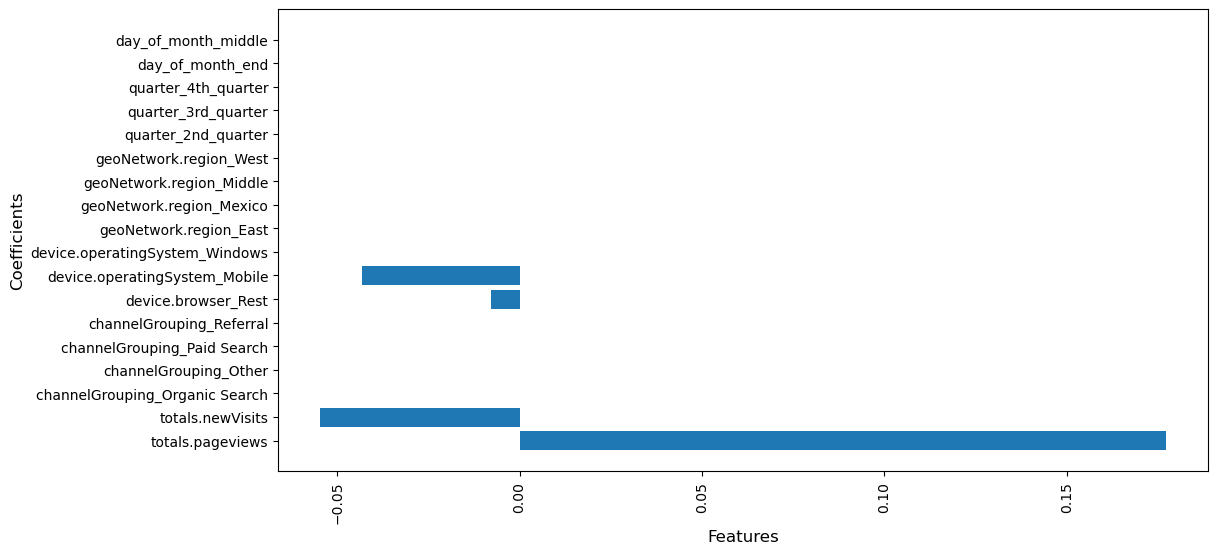

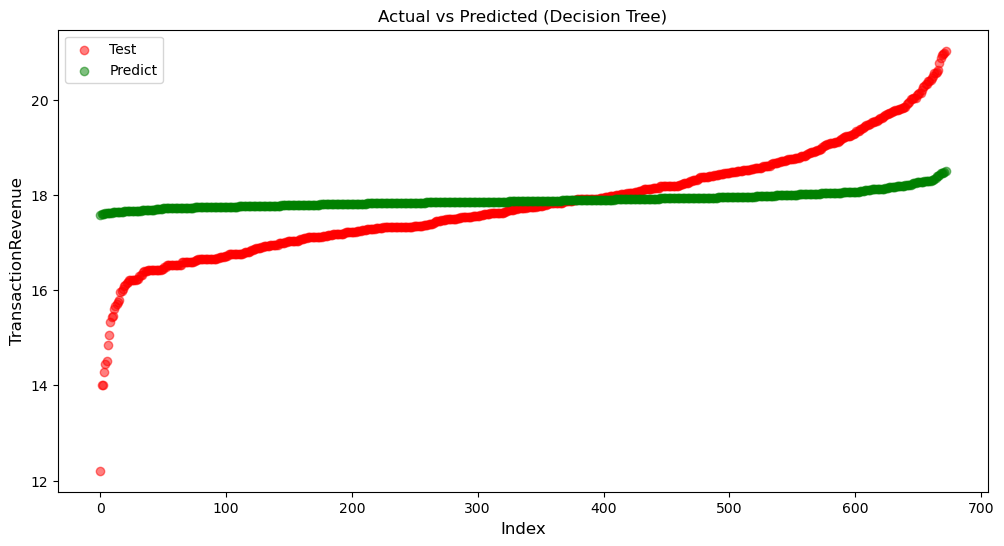

In [268]:
# lasso regression and ridge regression
from sklearn.linear_model import Lasso, Ridge

# Initialize the model
model = Lasso(alpha=0.1)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)

# Evaluate the model
dae = median_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print("Mean Squared Error lasso:", mse)
print("Mean Absolute Error lasso:", mae)
print("Median Absolute Error lasso:", dae)

# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validated scores
print('Cross-validated scores lasso :', -scores)

# Print the average score
print('Average score lasso:', -scores.mean())

#plot the coefficients
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.coef_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Coefficients', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_val)), np.sort(y_val), color='r', label='Test', alpha=0.5)
plt.scatter(range(len(y_pred)), np.sort(y_pred), color='g', label='Predict', alpha=0.5)
 
plt.xlabel('Index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Actual vs Predicted (Decision Tree)')
plt.legend()
plt.show()



# Ridge Regression

Mean Squared Error ridge: 1.1400499974253426
Mean Absolute Error ridge: 0.825505988303
Median Absolute Error ridge: 0.6508713715292167
Cross-validated scores ridge : [0.82993898 0.79810742 0.86191772 0.84541047 0.8038229 ]
Average score ridge: 0.8278394978315383


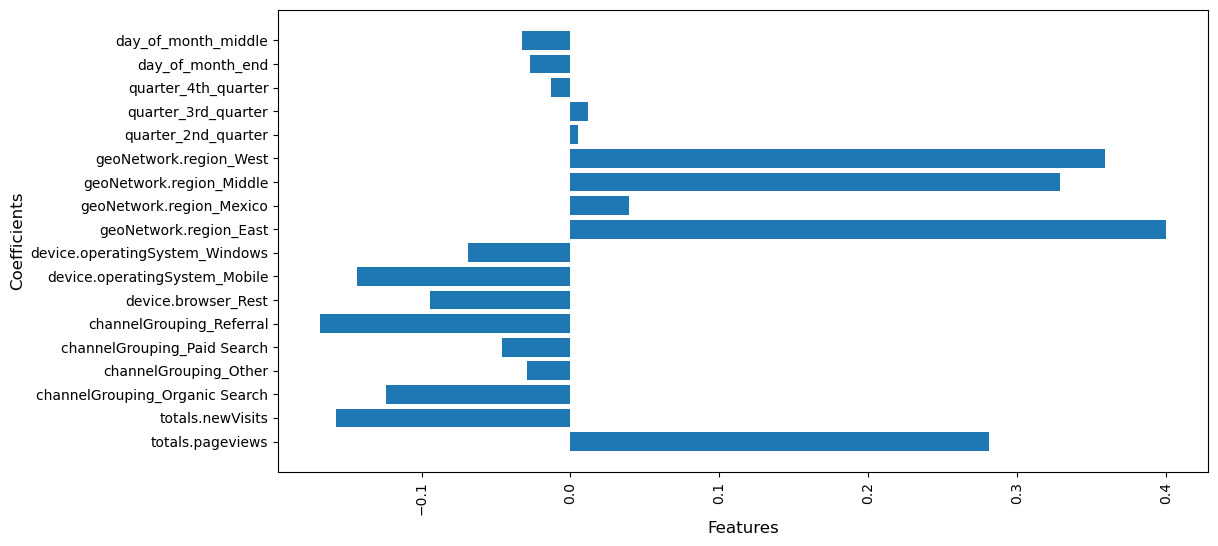

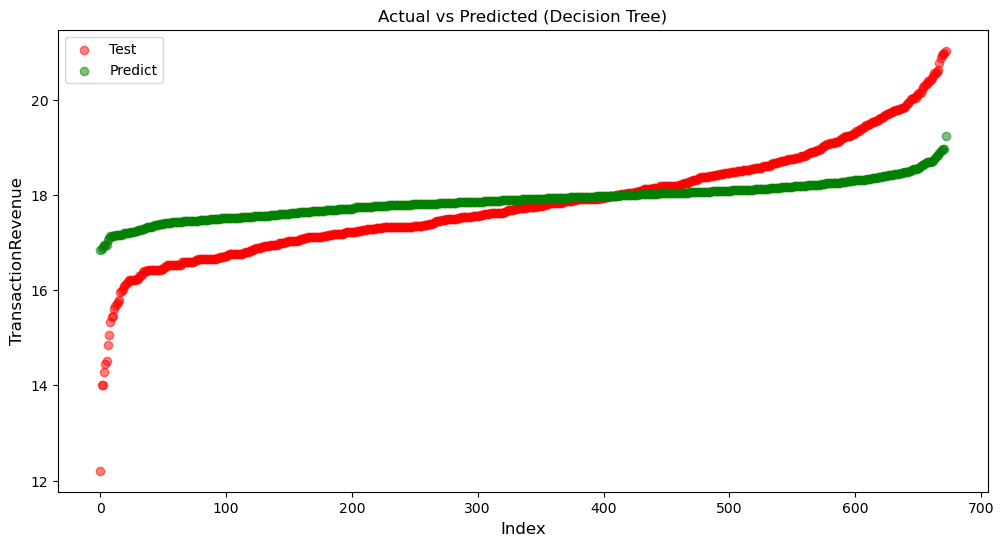

In [257]:
# Initialize the model
model = Ridge(alpha=0.1)

# Fit the model
model.fit(X_train_std, y_train)

# Make predictions
y_pred = model.predict(X_val_std)

# Evaluate the model
dae = median_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print("Mean Squared Error ridge:", mse)
print("Mean Absolute Error ridge:", mae)
print("Median Absolute Error ridge:", dae)

# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validated scores
print('Cross-validated scores ridge :', -scores)

# Print the average score
print('Average score ridge:', -scores.mean())

#plot the coefficients
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.coef_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Coefficients', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_val)), np.sort(y_val), color='r', label='Test', alpha=0.5)
plt.scatter(range(len(y_pred)), np.sort(y_pred), color='g', label='Predict', alpha=0.5)
 
plt.xlabel('Index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Actual vs Predicted (Decision Tree)')
plt.legend()
plt.show()


# Random Forest Regressor

Mean Squared Error rfr: 1.3375646157524708
Mean Absolute Error rfr: 0.8783361243799794
Median Absolute Error rfr: 0.6962797637300682
Cross-validated scores: [0.89700461 0.89117423 0.94628395 0.93436984 0.92170996]
Average score: 0.9181085167665032


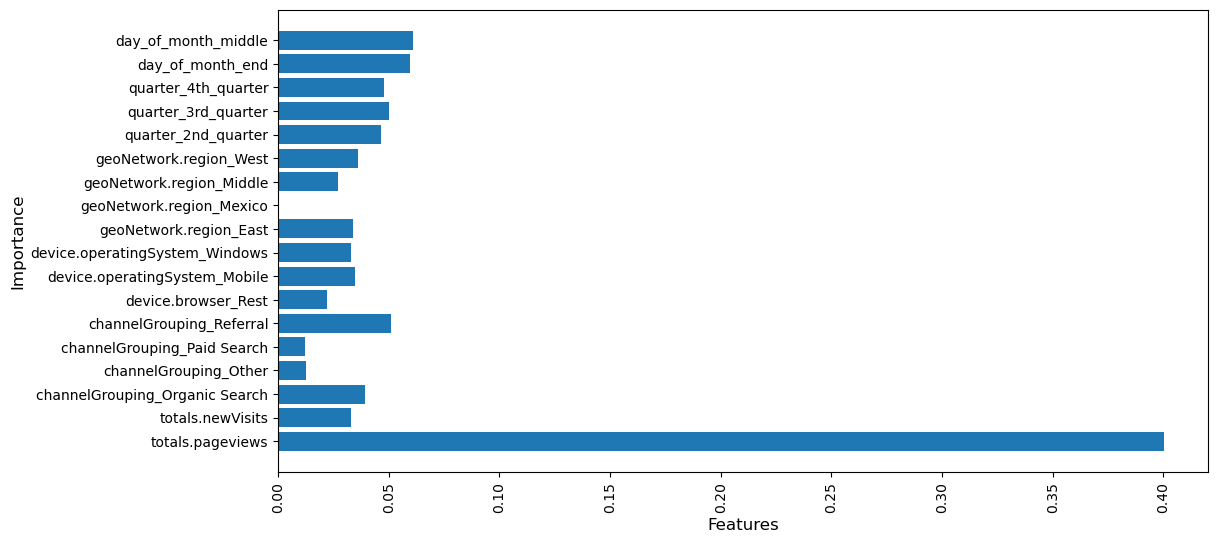

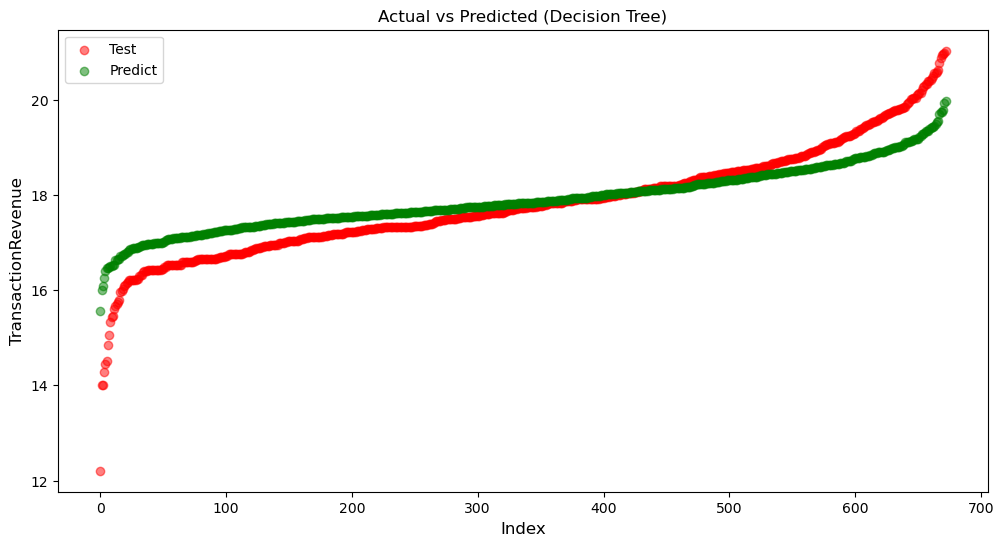

In [270]:
# other regression model
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)

# Evaluate the model
dae_rfr = median_absolute_error(y_val, y_pred)
mse_rfr = mean_squared_error(y_val, y_pred)
mae_rfr = mean_absolute_error(y_val, y_pred)




print("Mean Squared Error rfr:",mse_rfr)
print("Mean Absolute Error rfr:", mae_rfr)
print("Median Absolute Error rfr:", dae_rfr)


# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validated scores
print('Cross-validated scores:', -scores)

# Print the average score
print('Average score:', -scores.mean())


#plot the feature importance
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_val)), np.sort(y_val), color='r', label='Test', alpha=0.5)
plt.scatter(range(len(y_pred)), np.sort(y_pred), color='g', label='Predict', alpha=0.5)
 
plt.xlabel('Index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Actual vs Predicted (Decision Tree)')
plt.legend()
plt.show()


In [259]:
X_train.head(5)

,totals.pageviews,totals.newVisits,channelGrouping_Organic Search,channelGrouping_Other,channelGrouping_Paid Search,channelGrouping_Referral,device.browser_Rest,device.operatingSystem_Mobile,device.operatingSystem_Windows,geoNetwork.region_East,geoNetwork.region_Mexico,geoNetwork.region_Middle,geoNetwork.region_West,quarter_2nd_quarter,quarter_3rd_quarter,quarter_4th_quarter,day_of_month_end,day_of_month_middle
376668,18,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
80473,19,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1
21332,33,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1
174687,13,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1
777550,48,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


# XGBRegressor

Mean Squared Error xgb: 1.2992325824325592
Mean Absolute Error xgb: 0.8772853036473015
Median Absolute Error xgb: 0.7278556705954458


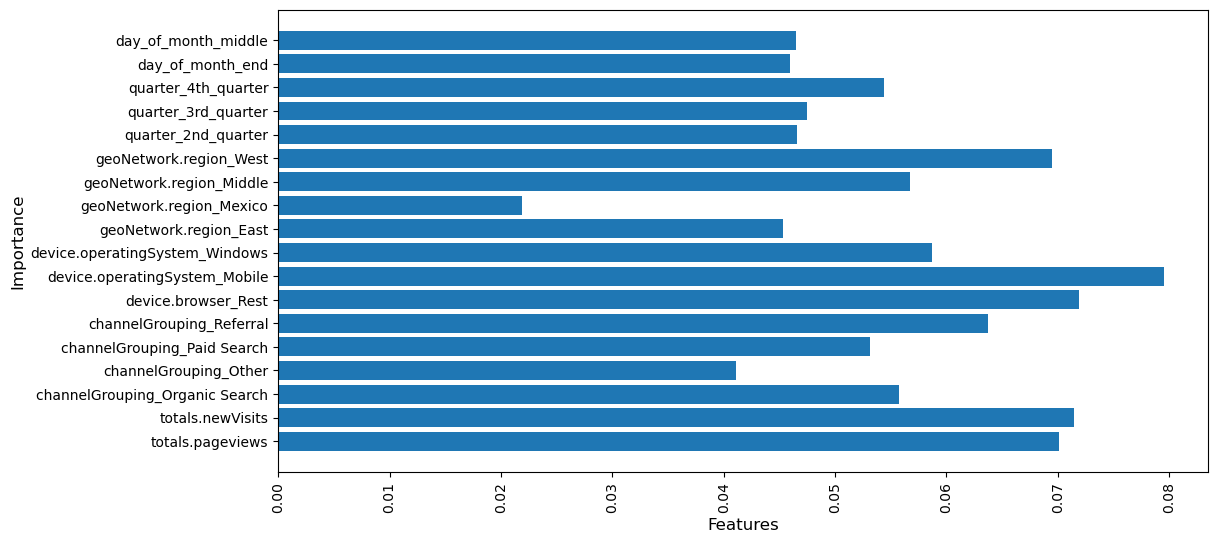

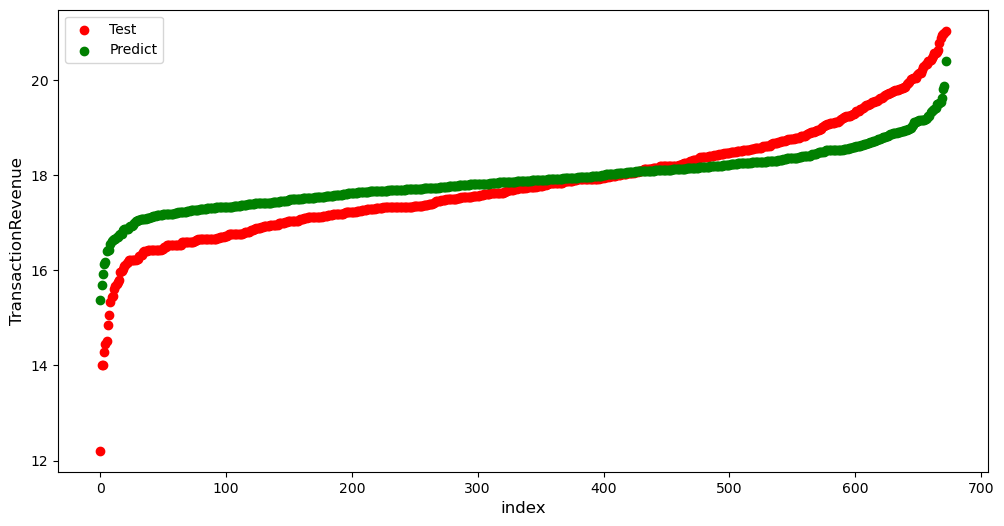

In [269]:
#xgb regression
#!pip install xgboost
import xgboost as xgb

# Initialize the model
model = xgb.XGBRegressor()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)

# Evaluate the model
dae = median_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print("Mean Squared Error xgb:", mse)
print("Mean Absolute Error xgb:", mae)
print("Median Absolute Error xgb:", dae)

#plot the feature importance
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=90)
plt.show()
 
# Deviation Plot between Predict and Test in different colors
 
plt.figure(figsize=(12,6))
plt.scatter(range(y_val.shape[0]), np.sort(y_val), color='r', label='Test')
plt.scatter(range(y_pred.shape[0]), np.sort(y_pred), color='g', label='Predict')
 
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.legend()
plt.show()


# Gradient Boosting Regressor

Mean Squared Error gbr: 1.1467647800902747
Mean Absolute Error gbr: 0.8223923829073463
Median Absolute Error gbr: 0.6565413583306068
Cross-validated scores gbr : [0.82479973 0.78861595 0.84836365 0.84216774 0.79993644]
Average score gbr: 0.8207767034728599


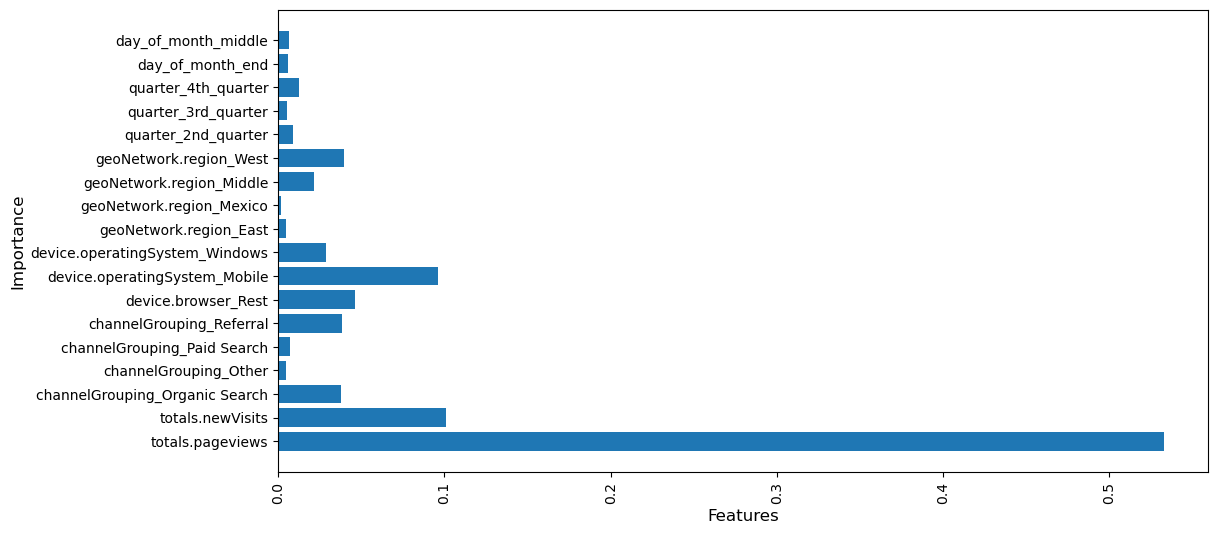

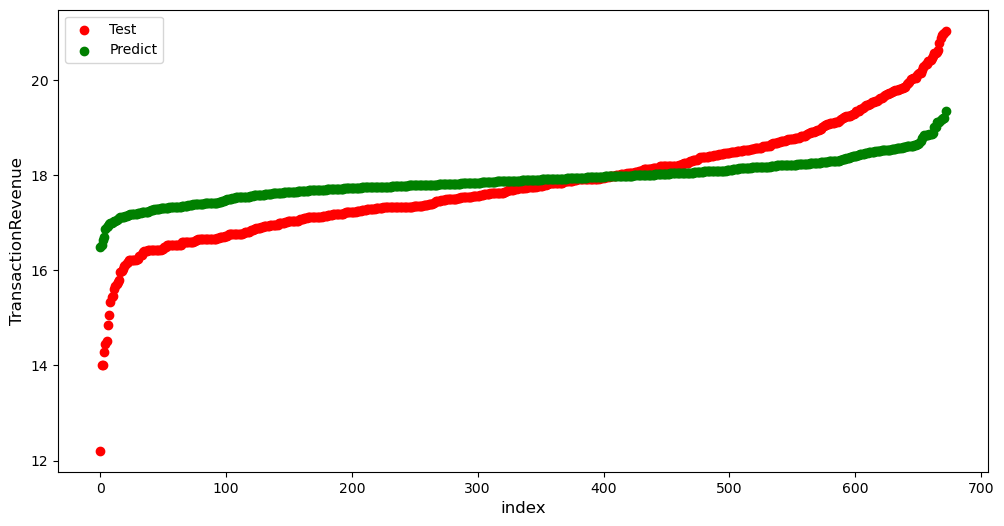

In [ ]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
 
# Initialize the model
model = GradientBoostingRegressor()
 
# Fit the model
model.fit(X_train, y_train)
 
# Make predictions
y_pred = model.predict(X_val)
 
# Evaluate the model
dae = median_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
 
print("Mean Squared Error gbr:", mse)
print("Mean Absolute Error gbr:", mae)
print("Median Absolute Error gbr:", dae)
 
# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
 
# Print the cross-validated scores
print('Cross-validated scores gbr :', -scores)
 
# Print the average score
print('Average score gbr:', -scores.mean())
 
#plot the feature importance
plt.figure(figsize=(12,6))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=90)
plt.show()
 
# Deviation Plot between Predict and Test in different colors
 
plt.figure(figsize=(12,6))
plt.scatter(range(y_val.shape[0]), np.sort(y_val), color='r', label='Test')
plt.scatter(range(y_pred.shape[0]), np.sort(y_pred), color='g', label='Predict')
 
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.legend()
plt.show()

# Adaboost Regressor

Mean Squared Error adb: 1.2179548914780314
Mean Absolute Error adb: 0.8652567266433344
Median Absolute Error adb: 0.7135659356236665
Cross-validated scores adb: [0.85188331 0.84130862 0.87249769 0.87851288 0.83654312]
Average score adb: 0.856149122380671


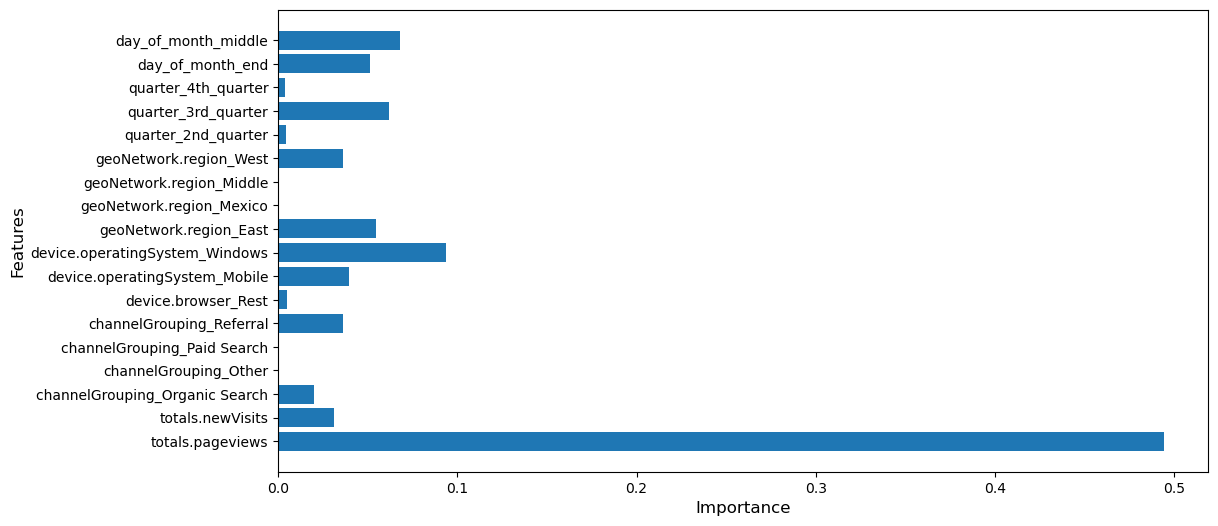

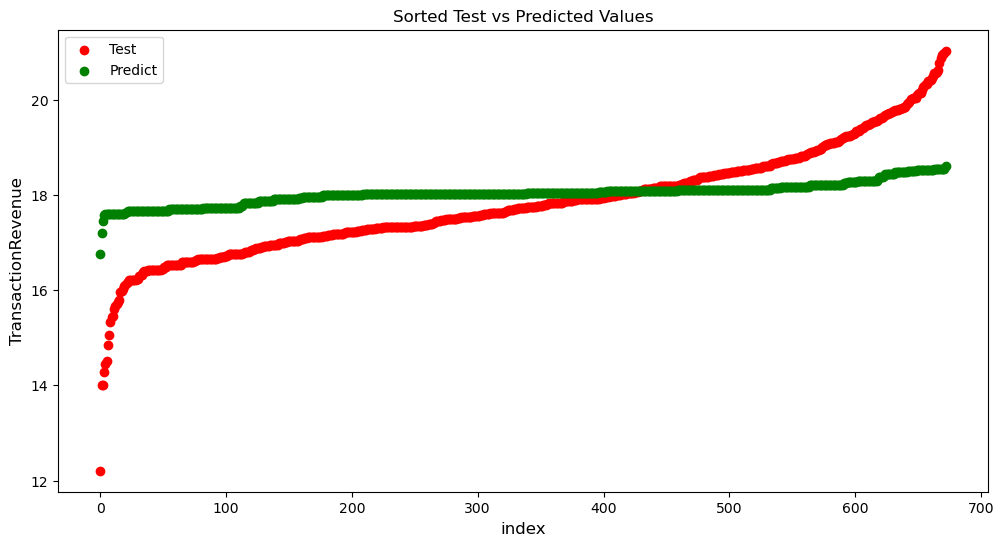

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
 
# Initialize the model
model = AdaBoostRegressor()
 
# Fit the model on the training data
model.fit(X_train, y_train)
 
# Make predictions on the test data
y_pred = model.predict(X_val)
 
# Evaluate the model
dae = median_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
 
print("Mean Squared Error adb:", mse)
print("Mean Absolute Error adb:", mae)
print("Median Absolute Error adb:", dae)
 
# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
 
# Print the cross-validated scores (negated to get positive values)
print('Cross-validated scores adb:', -scores)
 
# Print the average score
print('Average score adb:', -scores.mean())
 
# Plot the feature importance
plt.figure(figsize=(12,6))
# If your AdaBoostRegressor uses DecisionTreeRegressor as the base estimator (which is default),
# you can access feature importances. Otherwise, this might not be available.
if hasattr(model, 'feature_importances_'):
    plt.barh(X.columns, model.feature_importances_)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.show()
else:
    print('Feature importances are not available for the base estimator.')
 
# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_val)), np.sort(y_val), color='r', label='Test')
plt.scatter(range(len(y_pred)), np.sort(y_pred), color='g', label='Predict')
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Sorted Test vs Predicted Values')
plt.legend()
plt.show()

# Decision Tree Regressor

Mean Squared Error (Decision Tree): 1.9978825406502034
Mean Absolute Error (Decision Tree): 1.0860776062720932
Median Absolute Error (Decision Tree): 0.8675481825268321


Cross-validated scores (Decision Tree): [1.11981024 1.11049847 1.16704986 1.156069   1.16676503]
Average score (Decision Tree): 1.1440385216732942


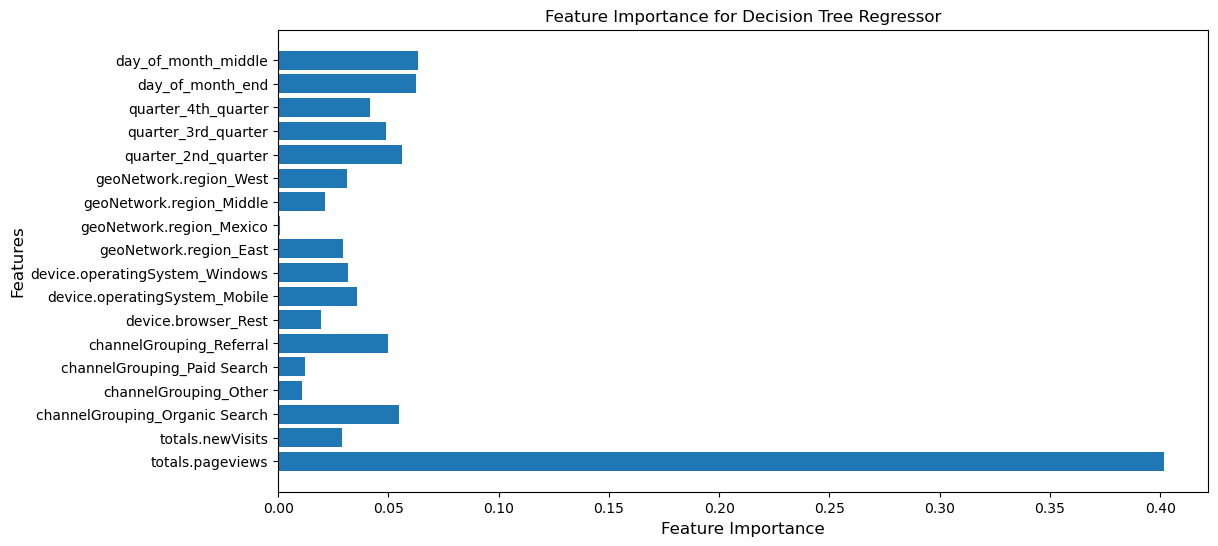

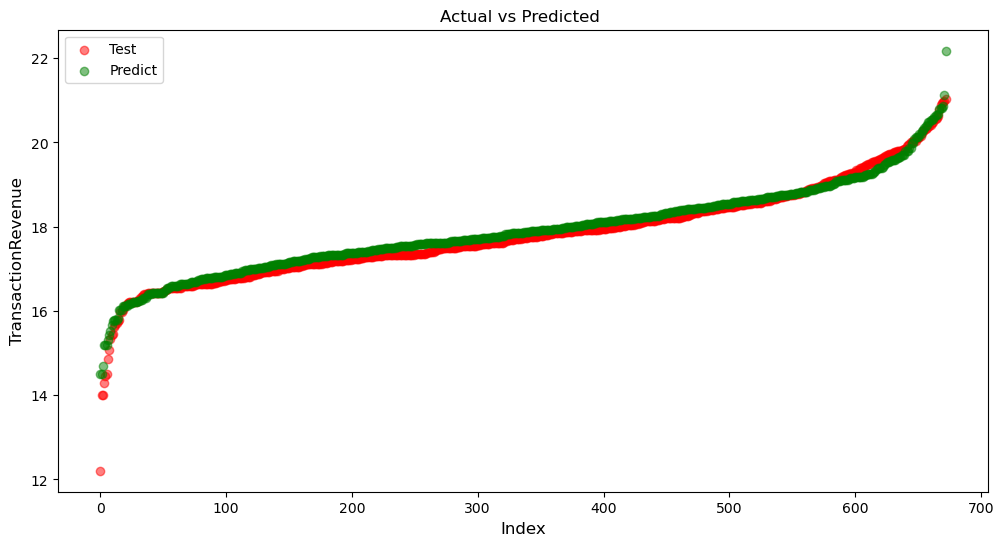

In [276]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
 
# Initialize the model
dt_model = DecisionTreeRegressor()
 
# Fit the model
dt_model.fit(X_train, y_train)
 
# Make predictions
y_pred_dt = dt_model.predict(X_val)
 
# Evaluate the model
mse_dt = mean_squared_error(y_val, y_pred_dt)
mae_dt = mean_absolute_error(y_val, y_pred_dt)
dae_dt = median_absolute_error(y_val, y_pred_dt)
 
print("Mean Squared Error (Decision Tree):", mse_dt)
print("Mean Absolute Error (Decision Tree):", mae_dt)
print("Median Absolute Error (Decision Tree):", dae_dt)
 
# Perform 5-fold cross validation
scores_dt = cross_val_score(dt_model, X, y, cv=5, scoring='neg_mean_absolute_error')
 
# Print the cross-validated scores (as positive values)
print('Cross-validated scores (Decision Tree):', -scores_dt)
 
# Print the average score
print('Average score (Decision Tree):', -scores_dt.mean())
 
# Plot the feature importance
plt.figure(figsize=(12,6))
plt.barh(X.columns, dt_model.feature_importances_)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance for Decision Tree Regressor')
plt.show()
 
# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_val)), np.sort(y_val), color='r', label='Test', alpha=0.5)
plt.scatter(range(len(y_pred_dt)), np.sort(y_pred_dt), color='g', label='Predict', alpha=0.5)
 
plt.xlabel('Index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Actual vs Predicted ')
plt.legend()
plt.show()
 

# Support Vector Regressor (SVR)

Mean Squared Error svr: 1.1412517516835905
Mean Absolute Error svr: 0.8179615217397801
Median Absolute Error svr: 0.6482610907306565
Cross-validated scores svr : [0.81935046 0.78637207 0.85351856 0.84887881 0.80325777]
Average score svr: 0.8222755334028413


/Users/macbookpro/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but SVR was fitted without feature names

/Users/macbookpro/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but SVR was fitted without feature names

/Users/macbookpro/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but SVR was fitted without feature names

/Users/macbookpro/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but SVR was fitted without feature names

/Users/macbookpro/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but SVR was fitted without feature names

/Users/macbookpro/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but SVR was fitted without feature names

/Users/macbookpro/anaconda3/lib/python3.11/site-packages/sklearn/base.

Feature: totals.pageviews, Score: 0.00012
Feature: totals.newVisits, Score: 0.00008
Feature: channelGrouping_Organic Search, Score: 0.00002
Feature: channelGrouping_Other, Score: 0.00000
Feature: channelGrouping_Paid Search, Score: 0.00000
Feature: channelGrouping_Referral, Score: -0.00006
Feature: device.browser_Rest, Score: 0.00001
Feature: device.operatingSystem_Mobile, Score: 0.00002
Feature: device.operatingSystem_Windows, Score: 0.00001
Feature: geoNetwork.region_East, Score: 0.00007
Feature: geoNetwork.region_Mexico, Score: 0.00000
Feature: geoNetwork.region_Middle, Score: -0.00003
Feature: geoNetwork.region_West, Score: -0.00002
Feature: quarter_2nd_quarter, Score: 0.00001
Feature: quarter_3rd_quarter, Score: -0.00000
Feature: quarter_4th_quarter, Score: -0.00001
Feature: day_of_month_end, Score: 0.00000
Feature: day_of_month_middle, Score: -0.00002


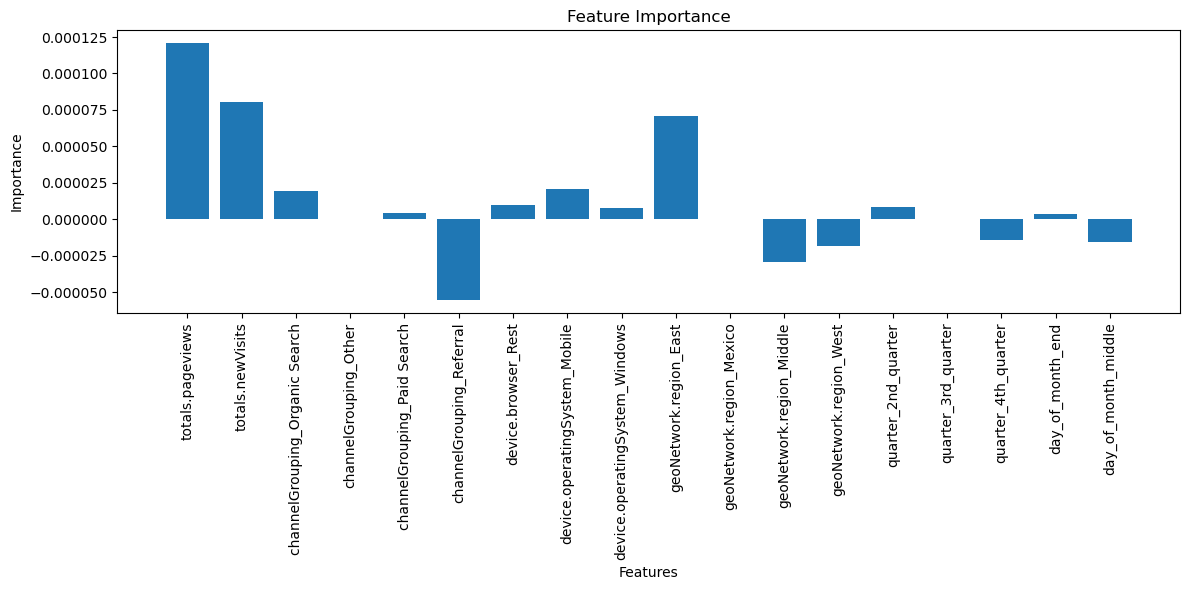

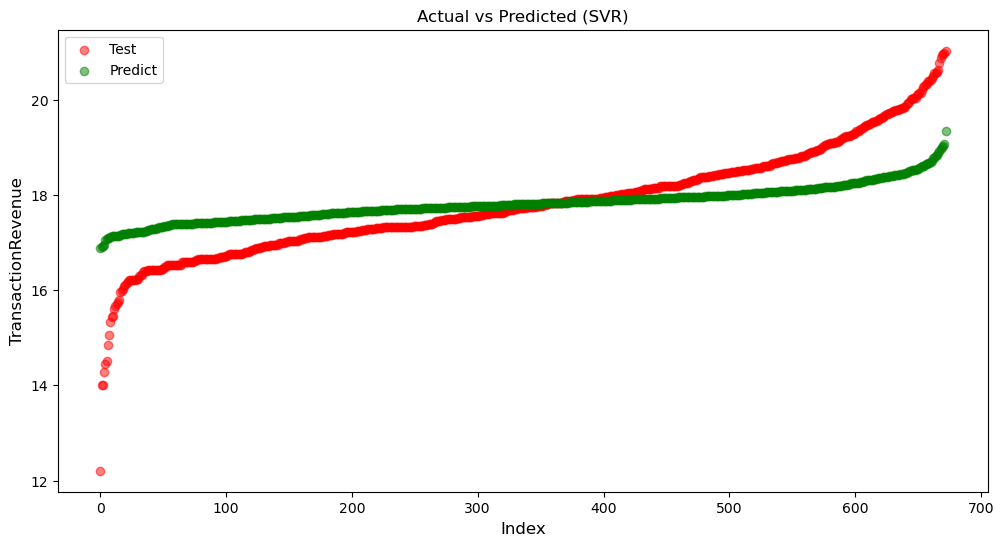

In [ ]:
# SVR
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance

# Initialize the model
model = SVR(kernel='linear')
 
# Fit the model
model.fit(X_train, y_train)
 
# Make predictions
y_pred = model.predict(X_val)
 
# Evaluate the model
dae = median_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
 
print("Mean Squared Error svr:", mse)
print("Mean Absolute Error svr:", mae)
print("Median Absolute Error svr:", dae)
 
# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
 
# Print the cross-validated scores
print('Cross-validated scores svr :', -scores)
 
# Print the average score
print('Average score svr:', -scores.mean())
 
# Perform permutation importance
results = permutation_importance(model, X, y, scoring='neg_mean_absolute_error')
importance = results.importances_mean

# Summarize feature importance with feature names
feature_names = X.columns
for i, v in enumerate(importance):
    print(f"Feature: {feature_names[i]}, Score: {v:.5f}")

# Create a bar chart with feature names
plt.figure(figsize=(12, 6))
plt.bar(range(len(importance)), importance, tick_label=feature_names)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.xticks(rotation='vertical')  # Rotate feature names for better readability
plt.ylabel('Importance')
plt.tight_layout()

# Display the plot
plt.show()

# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_val)), np.sort(y_val), color='r', label='Test', alpha=0.5)
plt.scatter(range(len(y_pred)), np.sort(y_pred), color='g', label='Predict', alpha=0.5)
 
plt.xlabel('Index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Actual vs Predicted (SVR)')
plt.legend()
plt.show()


# Hyperparameter Tuning

# Ridge Regression

In [ ]:
#Tuning on Ridge Regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Initialize the model
model = Ridge()

# Define the hyperparameters
hyperparameters = {'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using Ridge: ",-1*grid_search.best_score_)

Best parameters:  {'alpha': 0.1}
Mean Absolute Error using Ridge:  0.8269351094617203


# Lasso Regression

In [ ]:
#Tuning on Lasso Regression

# Initialize the model
model = Lasso()

# Define the hyperparameters
hyperparameters = {'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using Lasso: ",-1*grid_search.best_score_)

/Users/macbookpro/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.378e+01, tolerance: 5.805e-01

/Users/macbookpro/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.722e+00, tolerance: 5.802e-01

/Users/macbookpro/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.850e+00, tolerance: 5.789e-01

/Users/macbookpro/anacond

Best parameters:  {'alpha': 0.01}
Mean Absolute Error using Lasso:  0.8259380734231676


/Users/macbookpro/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.758e+02, tolerance: 5.578e-01



# Random Forest Regression

In [ ]:
#Tuning on Random Forest Regression

# Initialize the model
model = RandomForestRegressor()

# Define the hyperparameters
hyperparameters = {'n_estimators': [100, 200, 300, 400],
                   'max_depth': [2,4,6],
                   'min_samples_leaf': [1,2,3],
                   'min_samples_split': [2,5,10]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using Random Forest: ",-1*grid_search.best_score_)

Best parameters:  {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Mean Absolute Error using Random Forest:  0.8230250518844567


# XGB Regressor

In [ ]:
#Tuning on XGBoost Regressor

# Initialize the model
model = xgb.XGBRegressor(objective ='reg:squarederror')

# Define the hyperparameters
hyperparameters = {'n_estimators': [100, 200, 300, 400],
                   'max_depth': [2,4,6],
                   'learning_rate': [0.1, 0.01, 0.001]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using XGBRegressor: ",-1*grid_search.best_score_)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
Mean Absolute Error using XGBRegressor:  0.8217189880856097


# Gradient Boosting Regressor

In [ ]:
#Tuning on Gradient Boosting Regression

# Initialize the model
model = GradientBoostingRegressor()

# Define the hyperparameters
hyperparameters = {'n_estimators': [100, 200, 300],
                   'max_depth': [2,4,6],
                   'min_samples_leaf': [1,2,3],
                   'min_samples_split': [2,5,10]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using Gradient Boosting Regressor: ",-1*grid_search.best_score_)

Best parameters:  {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Mean Absolute Error using Gradient Boosting Regressor:  0.8215884413279481


# AdaBoost Regressor

In [ ]:
#Tuning on AdaBoost Regression Model

# Initialize the model
model = AdaBoostRegressor()

# Define the hyperparameters
hyperparameters = {'n_estimators': [100, 200, 300, 400],
                   'learning_rate': [0.1, 0.01, 0.001]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using AdaBoost Regressor: ",-1*grid_search.best_score_)

Best parameters:  {'learning_rate': 0.001, 'n_estimators': 300}
Mean Absolute Error using AdaBoost Regressor:  0.8322079794708366


# Decision Tree Regressor

In [ ]:
#Tuning on Decision Tree Regression Model

# Initialize the model
model = DecisionTreeRegressor()

# Define the hyperparameters
hyperparameters = {'max_depth': [2,4,6],
                   'min_samples_leaf': [1,2,3],
                   'min_samples_split': [2,5,10]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using Decision Tree Regressor: ",-1*grid_search.best_score_)

Best parameters:  {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean Absolute Error using Decision Tree Regressor:  0.8360712661480345


# Support Vector Regressor

In [ ]:
#Tuning on Support Vector Regression Model

# Initialize the model
model = SVR()

# Define the hyperparameters
hyperparameters = {'C': [0.1, 1, 10, 100],
                   'gamma': [1, 0.1, 0.01, 0.001]}

# Initialize the grid search
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='neg_mean_absolute_error')

# Fit the data to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Print the best score
print("Mean Absolute Error using SVR: ",-1*grid_search.best_score_)

Best parameters:  {'C': 10, 'gamma': 0.001}
Mean Absolute Error using SVR:  0.8195131150446098


In [ ]:
# new tech: MLflow, new tuning
# new feature


# Tpot autoML

In [ ]:
#tPoT
#df_8 = df_7.copy()

In [ ]:
#!pip install tpot


In [ ]:
"""from sklearn.model_selection import train_test_split

# Assuming df_7 is your DataFrame and 'target_column_name' is the name of your target column
X = df_8.drop('totals.transactionRevenue', axis=1)
y = df_8['totals.transactionRevenue']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
"""

"from sklearn.model_selection import train_test_split\n\n# Assuming df_7 is your DataFrame and 'target_column_name' is the name of your target column\nX = df_8.drop('totals.transactionRevenue', axis=1)\ny = df_8['totals.transactionRevenue']\n\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)\n"

In [ ]:
import tpot
import sklearn
print("TPOT version:", tpot.__version__)
print("Scikit-learn version:", sklearn.__version__)


#import tpot

TPOT version: 0.12.2
Scikit-learn version: 1.4.2


In [ ]:
from tpot import TPOTRegressor

tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1.1678523542051256

Generation 2 - Current best internal CV score: -1.1676071035243476

Generation 3 - Current best internal CV score: -1.1676071035243476

Generation 4 - Current best internal CV score: -1.1665710709438586

Generation 5 - Current best internal CV score: -1.1665548313731824

Best pipeline: ElasticNetCV(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), l1_ratio=0.35000000000000003, tol=0.01)


TPOTRegressor(generations=5, population_size=50, random_state=42, verbosity=2)

In [277]:
# print pipeline
best_model

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('elasticnetcv',
                 ElasticNetCV(l1_ratio=0.35000000000000003, random_state=42,
                              tol=0.01))])

In [ ]:
# tpot neg_mean_absolute_error


In [ ]:
print("The mean accuracy of the TPOT regressor is:", tpot.score(X_val, y_val))


The mean accuracy of the TPOT regressor is: -1.1332632051988358


In [ ]:
tpot.export('best_pipeline.py')


In [ ]:
# Make predictions
predictions = tpot.predict(X_val)

# Calculate MAE
mae = mean_absolute_error(y_val, predictions)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 0.8201842778139928


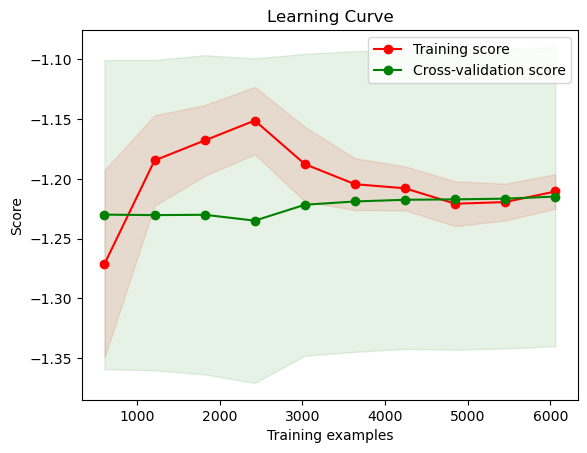

In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Assuming tpot is your TPOTRegressor object and it has been fitted
best_model = tpot.fitted_pipeline_

train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1,
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation for train and test sets
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

# Assuming X_train is your original training data and you want to recreate the polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly = poly.fit_transform(X_train)

# Access the ElasticNetCV model within the fitted pipeline
# It is assumed here that ElasticNetCV is the final step in the pipeline
elastic_model = best_model.steps[-1][1]  # Adjust the index if necessary based on your pipeline structure
# Assuming you have a DataFrame 'df' which was used as the training data initially
# and 'best_model' is your trained TPOT pipeline model

# Check if X_train is a DataFrame and get the column names
if isinstance(X_train, pd.DataFrame):
    original_feature_names = X_train.columns
else:
    print("not in dataframe")

not in dataframe


In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_train_df.head(5)

,totals.pageviews,totals.newVisits,channelGrouping_Organic Search,channelGrouping_Other,channelGrouping_Paid Search,channelGrouping_Referral,device.browser_Rest,device.operatingSystem_Mobile,device.operatingSystem_Windows,geoNetwork.region_East,geoNetwork.region_Mexico,geoNetwork.region_Middle,geoNetwork.region_West,quarter_2nd_quarter,quarter_3rd_quarter,quarter_4th_quarter,day_of_month_end,day_of_month_middle
0,-0.495546,1.375714,-0.480421,-0.158505,-0.159119,0.810069,-0.236371,-0.559480,-0.359690,1.518658,-0.033395,-0.400032,-1.121309,1.662469,-0.618994,-0.601229,-0.670088,-0.770078
1,-0.442444,1.375714,2.081507,-0.158505,-0.159119,-1.234463,-0.236371,-0.559480,2.780168,-0.658476,-0.033395,2.499798,-1.121309,1.662469,-0.618994,-0.601229,-0.670088,1.298570
2,0.300983,1.375714,-0.480421,-0.158505,-0.159119,0.810069,-0.236371,1.787374,-0.359690,-0.658476,-0.033395,-0.400032,0.891815,-0.601515,-0.618994,1.663260,-0.670088,1.298570
3,-0.761056,-0.726895,-0.480421,-0.158505,-0.159119,0.810069,-0.236371,-0.559480,-0.359690,1.518658,-0.033395,-0.400032,-1.121309,-0.601515,-0.618994,1.663260,-0.670088,1.298570
4,1.097513,-0.726895,-0.480421,-0.158505,-0.159119,-1.234463,-0.236371,1.787374,-0.359690,-0.658476,-0.033395,-0.400032,0.891815,-0.601515,-0.618994,-0.601229,-0.670088,-0.770078


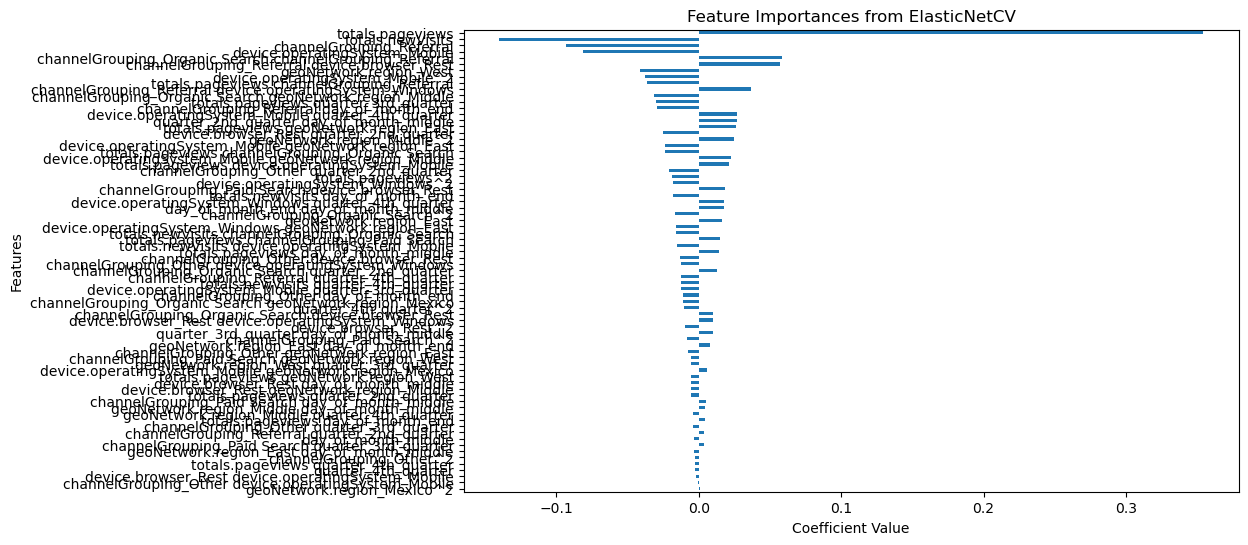

In [ ]:
original_feature_names = X_train_df.columns
# Access the ElasticNetCV model within the fitted pipeline
# Make sure to adjust the index if necessary based on your pipeline structure
# If ElasticNetCV is the last step in a sequential pipeline it's commonly -1 index,
# but if there's another step after (like a prediction step) it may be -2 or another index.
elastic_model = best_model.named_steps['elasticnetcv']  # This assumes your ElasticNetCV step is named 'elasticnetcv'

# Get the feature names for the polynomial features
# This assumes that the PolynomialFeatures step is named 'polynomialfeatures'
poly_transformer = best_model.named_steps['polynomialfeatures']
feature_names_poly = poly_transformer.get_feature_names_out(input_features=original_feature_names)

# Get the coefficients from the ElasticNetCV model
coefficients = elastic_model.coef_

# Create a series with the coefficients and the feature names
importance = pd.Series(coefficients, index=feature_names_poly)

# Since many coefficients may be zero, we'll focus on non-zero coefficients for the plot
non_zero_importance = importance[importance != 0].sort_values(key=np.abs)

# Plotting non-zero coefficients for visualization
plt.figure(figsize=(10, 6))
non_zero_importance.plot(kind='barh')
plt.title('Feature Importances from ElasticNetCV')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()


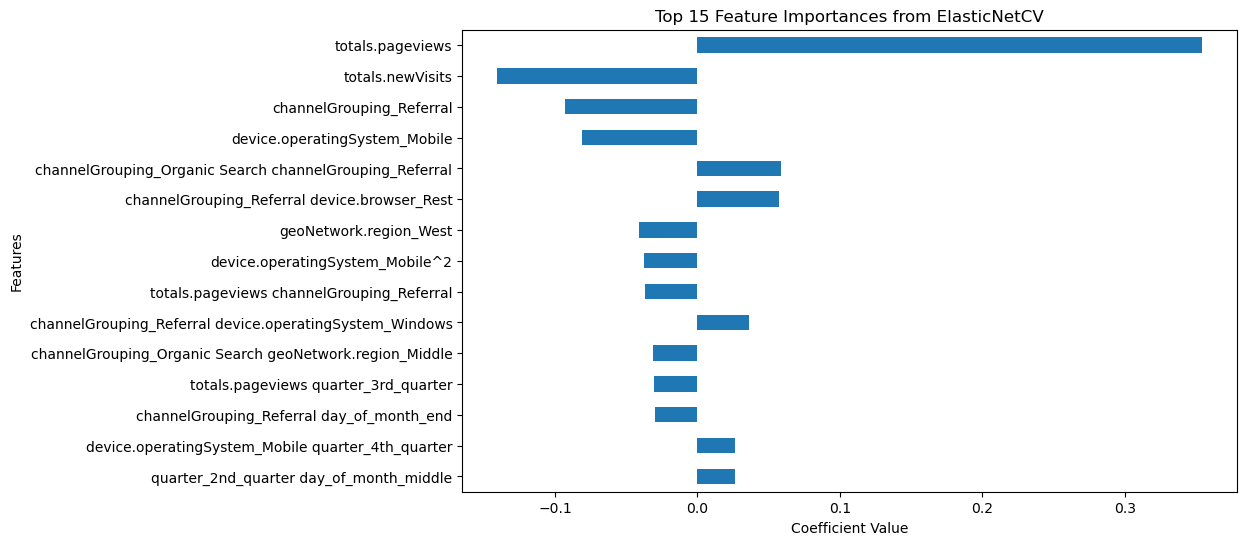

In [ ]:
# Sort the features by absolute value of coefficients
sorted_importances = non_zero_importance.abs().sort_values(ascending=False)

# Get the top 10 features and their coefficients
top_15_features = sorted_importances.head(15).index
top_15_coefficients = non_zero_importance.loc[top_15_features]

# Plotting top 10 features for visualization
plt.figure(figsize=(10, 6))
top_15_coefficients.plot(kind='barh')
plt.title('Top 15 Feature Importances from ElasticNetCV')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # To have the highest value on top
plt.show()


In [ ]:
tpot

TPOTRegressor(generations=5, population_size=50, random_state=42, verbosity=2)

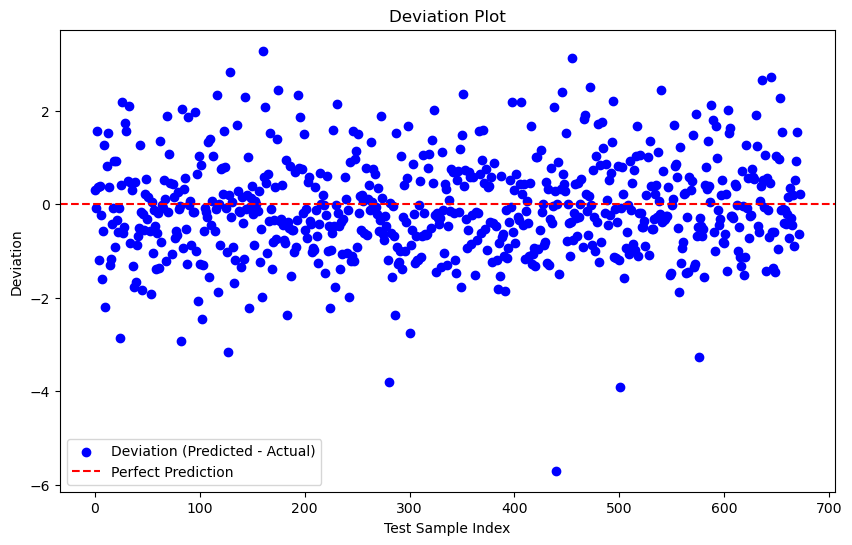

In [ ]:
 
# Deviation Plot between Predict and Test in different colors
# Assuming X_val is your test feature set and tpot is your trained TPOT object
predictions = tpot.predict(X_val)
# Assuming y_test is your actual target values for the test set
deviations = y_val - predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(deviations)), deviations, c='blue', label='Deviation (Predicted - Actual)')
plt.axhline(y=0, color='r', linestyle='--', label='Perfect Prediction')
plt.title('Deviation Plot')
plt.xlabel('Test Sample Index')
plt.ylabel('Deviation')
plt.legend()
plt.show()


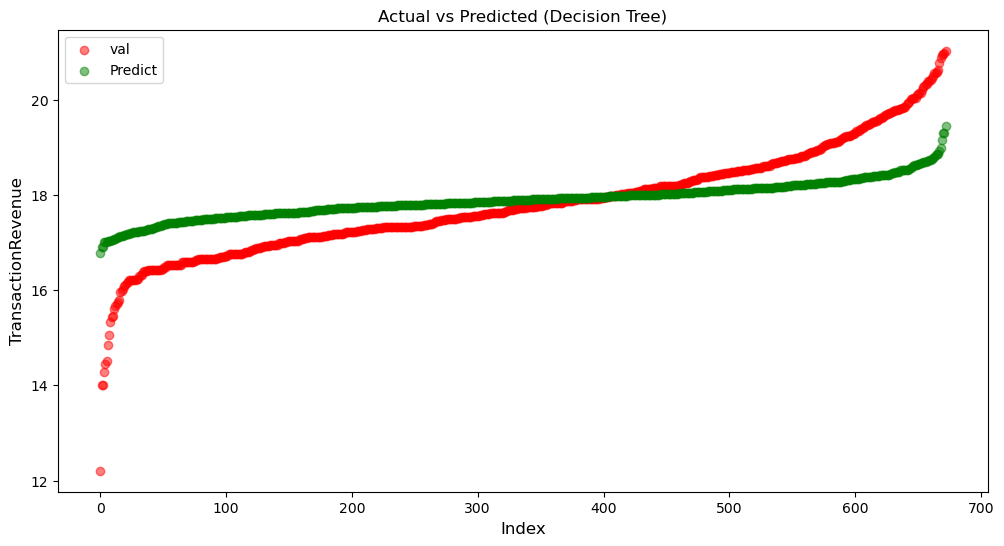

In [ ]:
# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_val)), np.sort(y_val), color='r', label='val', alpha=0.5)
plt.scatter(range(len(predictions)), np.sort(predictions), color='g', label='Predict', alpha=0.5)
 
plt.xlabel('Index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Actual vs Predicted (Decision Tree)')
plt.legend()
plt.show()


In [272]:
X_test_std = scaler.transform(X_test)


# Make predictions
predictions = tpot.predict(X_test_std)

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 0.8287761706222666


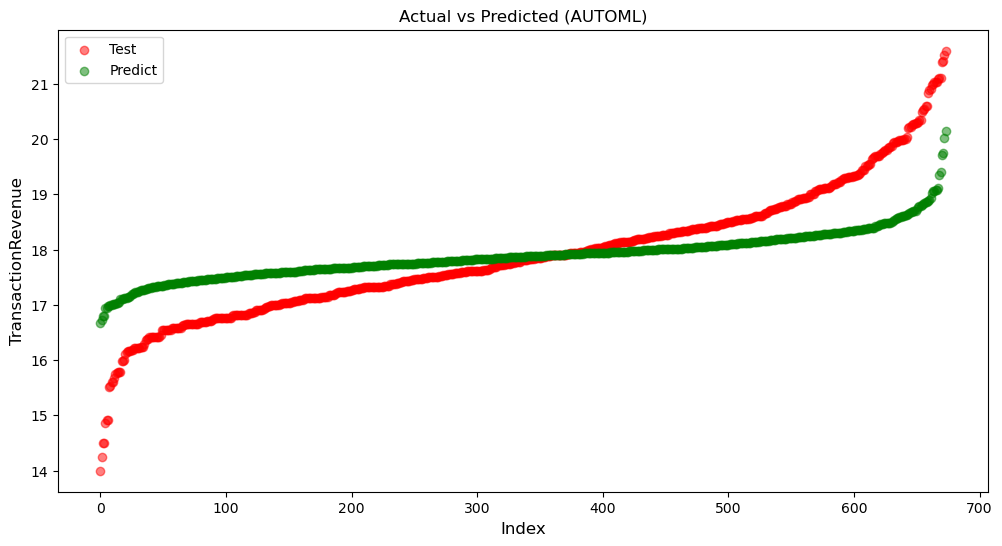

In [275]:
# Deviation Plot between Predict and Test in different colors
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_test)), np.sort(y_test), color='r', label='Test', alpha=0.5)
plt.scatter(range(len(predictions)), np.sort(predictions), color='g', label='Predict', alpha=0.5)
 
plt.xlabel('Index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Actual vs Predicted (AUTOML)')
plt.legend()
plt.show()